<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ensembling

This copy increases the number of learners from 5 to 10.

Testing Bulk data. We create a new dataframe that has the same columns as the bulk data. Then we test on the bulkdata (test data).

- With dropout, the model reached 92% on bulk data.
- Hihger accuracy on traning data does not necessarily mean high test accuracy.

### TODO
- Try ensembling:
  - With random seeds, there are too many variability in results.
  - Hopefully ensembling may provide better results
- Try data augmentation.
  - Random swap: swapping random columns.
- Try a new loss function.
  - Hexagon (7x8) with MSELoss
  1. Predict 56 outputs
  2. Create a hexagon
  3. MSE with the target
- Try Random Forest.
- Try Gradient boosting.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

In [4]:
# path = Path('./data/circadian/')

In [5]:
import os
path = Path(os.path.expandvars('$SCRATCH/data/circadian'))

## Data

Preparing scRNA-seq data for training.

In [6]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)
data = raw_data.set_index('gene').T
# Normalizing the data to have mean of 0 and standard deviation of 1
data = (data - data.mean(axis=0)) / data.std(axis=0)
df = data.join(meta_data.set_index('cell_name'))
df['ZT'] = pd.Categorical(df['ZT'])
df['code'] = df['ZT'].cat.codes

In [7]:
df['ZT']

AAACAGCCAACCCTAA-6    ZT18
AAACCAACAGTAAAGC-6    ZT18
AAACCGAAGGTCCTAG-6    ZT18
AAAGCACCATTGTCCT-6    ZT18
AAAGGACGTGAGGTGA-6    ZT18
                      ... 
TTGCCCGTCGCACAAT-7    ZT06
TTGCGTCTCTTAGTCT-7    ZT06
TTGGGTTAGCCACAAT-7    ZT06
TTTAGCTTCAGGAAGC-7    ZT06
TTTGGTAAGGAAGTAT-7    ZT06
Name: ZT, Length: 15992, dtype: category
Categories (6, object): ['ZT02', 'ZT06', 'ZT10', 'ZT14', 'ZT18', 'ZT22']

In [8]:
df['ZT'].cat.codes

AAACAGCCAACCCTAA-6    4
AAACCAACAGTAAAGC-6    4
AAACCGAAGGTCCTAG-6    4
AAAGCACCATTGTCCT-6    4
AAAGGACGTGAGGTGA-6    4
                     ..
TTGCCCGTCGCACAAT-7    1
TTGCGTCTCTTAGTCT-7    1
TTGGGTTAGCCACAAT-7    1
TTTAGCTTCAGGAAGC-7    1
TTTGGTAAGGAAGTAT-7    1
Length: 15992, dtype: int8

In [9]:
df[:3]

,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Mpp6,Ralgps1,Zfp580,Sept8,Cfap52,Arhgap27,F730043M19Rik,Bora,ZT,code
AAACAGCCAACCCTAA-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,1.122616,2.084872,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4
AAACCAACAGTAAAGC-6,-0.094012,-0.032904,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,-0.554376,-0.619790,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,2.058709,ZT18,4
AAACCGAAGGTCCTAG-6,-0.094012,-0.251429,-0.084206,-0.118838,-0.084834,-0.183315,-0.255395,-0.062888,-0.092432,-0.073209,...,0.451819,0.281764,-0.036734,-0.036734,-0.036734,-0.036734,-0.036734,-0.318222,ZT18,4


In [10]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [0,1,2,3,4,5,0,1,2,3,4,5]

The bulk data contains more columns than scRNA-seq data.

In [11]:
cols = set(list(df.columns) + list(bulk_data.columns))
len(cols)

10910

### Bulk + scRNA-seq

Instead of joining tables, we create a new table with the same shape as the bulk data with normally distributed random numbers. Then, we overwrite columns from scRNA-seq into this new table.

In [12]:
# New dataframe (table) with normally distributed random numbers
df2 = pd.DataFrame(np.random.normal(size=(15992, 9482)), columns=bulk_data.columns)
df.reset_index(inplace=True)
df2.update(df)
df2[:3]

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
0,-1.310936,1.084080,0.557752,0.068516,1.250520,0.899236,-0.043890,1.686979,0.666409,0.234600,...,-0.166754,1.147664,0.565281,0.546185,2.159961,-0.401256,-1.362596,1.155770,-2.221839,4.0
1,-0.065980,-0.872108,-0.181456,-2.391875,0.185467,0.522949,-0.387448,-0.189915,-1.419028,-0.363165,...,-0.166754,0.292927,-0.743745,0.278026,-0.784713,-0.401256,-0.399848,0.826073,0.819074,4.0
2,-1.596259,0.738870,0.212841,0.087609,0.248521,-0.414160,1.673901,0.122900,-0.126748,1.131247,...,10.777388,-0.751939,0.337363,-0.252565,0.821473,-0.401256,0.463269,-0.413481,-0.764481,4.0


## Using Pytorch

In [13]:
t_dep = tensor(df2['code'], dtype=torch.long)
indep_cols = list(df2.columns)[:-1]
t_indep = tensor(df2[indep_cols].values, dtype=torch.float32)

In [14]:
tst_dep = tensor(bulk_data['code'], dtype=torch.long)
tst_indep_cols = list(bulk_data.columns)[:-1]
tst_indep = tensor(bulk_data[indep_cols].values, dtype=torch.float32)
tst_indep

/tmp/job.9562522/ipykernel_131903/1370009161.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(bulk_data['code'], dtype=torch.long)


tensor([[ 1.1054,  1.7349, -1.0005,  ...,  0.1433, -0.5614, -0.5629],
        [ 0.1407,  0.3628,  0.2168,  ..., -1.1979,  1.1994,  0.0943],
        [-0.8167, -1.0595,  0.3766,  ...,  1.8283, -1.9395, -1.7678],
        ...,
        [-0.6048, -1.0751,  0.9168,  ...,  0.1089, -0.2552, -0.3438],
        [ 0.4233,  0.0204,  0.0723,  ..., -1.3010, -0.1021, -1.0376],
        [ 1.0372,  0.7136, -0.5212,  ...,  1.8627,  0.4338, -0.7820]])

In [15]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df2)

In [16]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(12794, 3198)

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [17]:
# set_seed(42)
trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=256, shuffle=True, num_workers=2)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=512, shuffle=False, num_workers=2)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([256, 9481]), tensor([0, 4, 5, 0, 0, 5, 2, 2, 2, 3]))

In [18]:
tst_dl = DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=2)

In [19]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
astats = ActivationStats(nn.ReLU)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [20]:
# set_seed(42)
model = nn.Sequential(*[nn.Linear(9481, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 6)])
learn = TrainLearner(model, dls, lr=.01, loss_func=F.cross_entropy, cbs=cbs)

In [21]:
learn.summary()

Tot params: 958906; MFLOPS: 1.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Linear|(256, 9481)|(256, 100)|948200|0.9|
|ReLU|(256, 100)|(256, 100)|0|0.0|
|Linear|(256, 100)|(256, 100)|10100|0.0|
|ReLU|(256, 100)|(256, 100)|0|0.0|
|Linear|(256, 100)|(256, 6)|606|0.0|


## Data Augmentation

We randomly select two columns and swap them.

In [22]:
xb,_ = next(iter(dls.train))
xbt = xb[:5,:10]
xbt

tensor([[ 1.1948e+00, -5.8443e-01, -1.1477e+00,  9.0944e-01,  3.9623e-02,
         -9.9230e-02, -7.3101e-01, -1.8992e-01,  1.7968e-01,  2.3460e-01],
        [-1.1627e+00, -6.9950e-01,  6.4544e-01,  1.7806e-03, -6.9764e-01,
         -6.4811e-01, -3.8745e-01, -6.5914e-01,  5.5192e-01, -8.1149e-01],
        [ 6.1427e-01,  1.3142e+00, -5.9002e-01, -1.5508e+00,  4.4812e-01,
         -1.5394e+00, -4.3890e-02,  4.3572e-01, -9.5376e-01,  2.3268e+00],
        [-1.4344e+00, -7.5704e-01, -2.5802e+00, -9.6525e-01, -1.5199e+00,
          2.1803e-01, -4.3890e-02, -8.1555e-01, -1.1353e+00, -8.1149e-01],
        [ 6.3958e-01,  1.0265e+00,  6.5484e-01, -1.1758e+00, -1.3561e+00,
          1.0777e+00, -3.8745e-01,  9.0494e-01, -8.9642e-01,  2.0279e+00]])

In [23]:
tmp = xbt[:,1].detach().clone()
xbt[:,1] = xbt[:,0]
xbt[:,0] = tmp
xbt

tensor([[-5.8443e-01,  1.1948e+00, -1.1477e+00,  9.0944e-01,  3.9623e-02,
         -9.9230e-02, -7.3101e-01, -1.8992e-01,  1.7968e-01,  2.3460e-01],
        [-6.9950e-01, -1.1627e+00,  6.4544e-01,  1.7806e-03, -6.9764e-01,
         -6.4811e-01, -3.8745e-01, -6.5914e-01,  5.5192e-01, -8.1149e-01],
        [ 1.3142e+00,  6.1427e-01, -5.9002e-01, -1.5508e+00,  4.4812e-01,
         -1.5394e+00, -4.3890e-02,  4.3572e-01, -9.5376e-01,  2.3268e+00],
        [-7.5704e-01, -1.4344e+00, -2.5802e+00, -9.6525e-01, -1.5199e+00,
          2.1803e-01, -4.3890e-02, -8.1555e-01, -1.1353e+00, -8.1149e-01],
        [ 1.0265e+00,  6.3958e-01,  6.5484e-01, -1.1758e+00, -1.3561e+00,
          1.0777e+00, -3.8745e-01,  9.0494e-01, -8.9642e-01,  2.0279e+00]])

In [24]:
import random

In [25]:
def _random_swap(x):
    """Swap two columns randomly."""
    n_cols = x.shape[1]
    a = random.randint(0, n_cols-1)
    b = random.randint(0, n_cols-1)
    tmp = x[:,a].detach().clone()
    x[:,a] = x[:,b]
    x[:,b] = tmp
    return x

In [26]:
_random_swap(xbt)

tensor([[-5.8443e-01,  1.1948e+00, -1.1477e+00,  1.7968e-01,  3.9623e-02,
         -9.9230e-02, -7.3101e-01, -1.8992e-01,  9.0944e-01,  2.3460e-01],
        [-6.9950e-01, -1.1627e+00,  6.4544e-01,  5.5192e-01, -6.9764e-01,
         -6.4811e-01, -3.8745e-01, -6.5914e-01,  1.7806e-03, -8.1149e-01],
        [ 1.3142e+00,  6.1427e-01, -5.9002e-01, -9.5376e-01,  4.4812e-01,
         -1.5394e+00, -4.3890e-02,  4.3572e-01, -1.5508e+00,  2.3268e+00],
        [-7.5704e-01, -1.4344e+00, -2.5802e+00, -1.1353e+00, -1.5199e+00,
          2.1803e-01, -4.3890e-02, -8.1555e-01, -9.6525e-01, -8.1149e-01],
        [ 1.0265e+00,  6.3958e-01,  6.5484e-01, -8.9642e-01, -1.3561e+00,
          1.0777e+00, -3.8745e-01,  9.0494e-01, -1.1758e+00,  2.0279e+00]])

In [27]:
def random_swap(x, max_swaps=10):
    """Swap two columns randomly by picking a random number."""
    swaps = random.randint(0, 10)
    _random_swap(x)
    return x

In [28]:
random_swap(xbt)

tensor([[-5.8443e-01,  1.1948e+00, -1.1477e+00,  1.7968e-01, -1.8992e-01,
         -9.9230e-02, -7.3101e-01,  3.9623e-02,  9.0944e-01,  2.3460e-01],
        [-6.9950e-01, -1.1627e+00,  6.4544e-01,  5.5192e-01, -6.5914e-01,
         -6.4811e-01, -3.8745e-01, -6.9764e-01,  1.7806e-03, -8.1149e-01],
        [ 1.3142e+00,  6.1427e-01, -5.9002e-01, -9.5376e-01,  4.3572e-01,
         -1.5394e+00, -4.3890e-02,  4.4812e-01, -1.5508e+00,  2.3268e+00],
        [-7.5704e-01, -1.4344e+00, -2.5802e+00, -1.1353e+00, -8.1555e-01,
          2.1803e-01, -4.3890e-02, -1.5199e+00, -9.6525e-01, -8.1149e-01],
        [ 1.0265e+00,  6.3958e-01,  6.5484e-01, -8.9642e-01,  9.0494e-01,
          1.0777e+00, -3.8745e-01, -1.3561e+00, -1.1758e+00,  2.0279e+00]])

In [29]:
class RandomSwap(nn.Module):
    def __init__(self, max_swaps=10):
        super().__init__()
        self.max_swaps = max_swaps

    def forward(self, x):
        return random_swap(x, self.max_swaps)

In [30]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [31]:
from functools import partial

In [32]:
tfms = nn.Sequential(RandomSwap(3000))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [33]:
# set_seed(42)
model = nn.Sequential(*[nn.Linear(9481, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 6)])

In [34]:
def get_model():
    return nn.Sequential(*[nn.Linear(9481, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 6)])

In [35]:
cbs = cbs

In [36]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=1, cbs=[SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
xb[:5,:10]

tensor([[ 3.7776e-01, -9.2964e-01, -1.0492e-01, -9.9476e-01,  1.8462e-04,
          6.4185e-02, -7.3101e-01, -8.1555e-01, -6.3224e-01, -8.1149e-01],
        [ 3.2716e-01, -3.5429e-01,  1.4170e+00,  2.4203e-02, -5.0383e-01,
         -2.0615e+00,  2.0175e+00,  2.7931e-01, -7.4685e-01, -3.6316e-01],
        [ 5.9420e-01, -7.5704e-01, -6.6461e-01,  1.3894e-01,  1.2160e+00,
         -1.1690e+00,  3.0481e+00, -6.5914e-01,  2.1966e+00, -6.6205e-01],
        [-8.6550e-01,  1.0265e+00,  1.1075e+00,  1.1331e+00,  3.6042e-02,
         -3.4567e-01, -4.3890e-02,  1.9998e+00, -8.4761e-01,  1.4301e+00],
        [ 9.9284e-01, -3.5429e-01, -6.7970e-01, -6.6015e-01,  1.4211e+00,
         -2.2630e+00, -4.3890e-02, -5.0273e-01, -1.1815e+00, -5.1261e-01]])

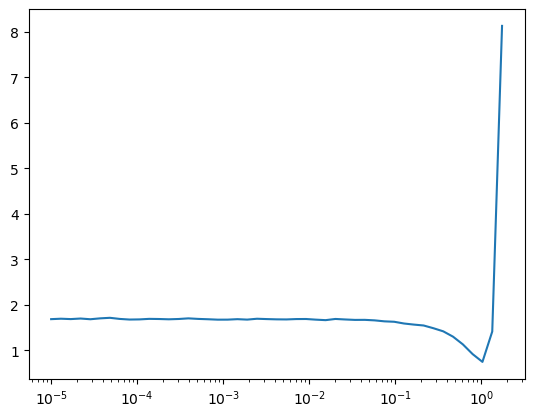

In [37]:
TrainLearner(model, dls, lr=.01, loss_func=F.cross_entropy, cbs=cbs).lr_find()

In [38]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [39]:
t1 = torch.randn((3,4))
t2 = torch.randn((3,4))
t3 = torch.stack((t1, t2))
t3

tensor([[[-0.1023,  0.0039,  1.1939,  1.0740],
         [ 0.3656,  1.3018, -0.5535, -1.5154],
         [-1.3778, -0.7172,  0.2436,  0.4247]],

        [[-1.7828, -1.3555,  0.4915,  0.4777],
         [ 0.5539,  0.2376, -0.9292,  1.6535],
         [ 0.2009, -0.4545, -0.1666,  2.9378]]])

In [40]:
t3.shape

torch.Size([2, 3, 4])

In [41]:
t3.mean(0)

tensor([[-0.9426, -0.6758,  0.8427,  0.7758],
        [ 0.4598,  0.7697, -0.7413,  0.0690],
        [-0.5884, -0.5859,  0.0385,  1.6812]])

In [42]:
t3.mean(0).argmax(1)

tensor([2, 1, 3])

accuracy,loss,epoch,train,time
0.385,1.690,0,True,00:01
0.611,1.529,0,False,00:00
0.690,1.257,1,True,00:01
0.726,1.028,1,False,00:00
0.826,0.743,2,True,00:01
0.891,0.573,2,False,00:00
0.957,0.358,3,True,00:01
0.951,0.324,3,False,00:00
0.991,0.167,4,True,00:01
0.960,0.221,4,False,00:00


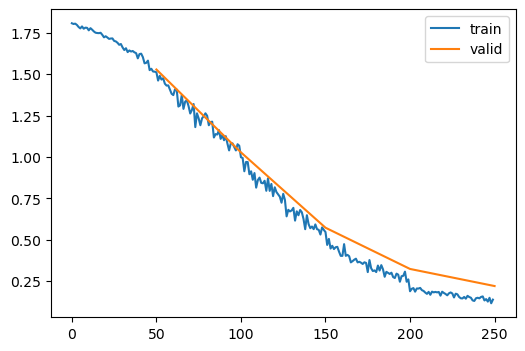

In [43]:
learn1 = TrainLearner(get_model(), dls, lr=.03, loss_func=F.cross_entropy, cbs=cbs)
learn1.fit(5)

accuracy,loss,epoch,train,time
0.394,1.696,0,True,00:01
0.538,1.553,0,False,00:00
0.632,1.302,1,True,00:01
0.675,1.095,1,False,00:00
0.786,0.811,2,True,00:01
0.832,0.639,2,False,00:00
0.936,0.407,3,True,00:01
0.937,0.357,3,False,00:00
0.987,0.186,4,True,00:01
0.960,0.230,4,False,00:00


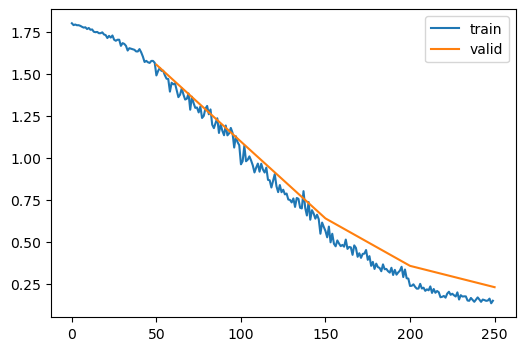

In [44]:
learn2 = TrainLearner(get_model(), dls, lr=.03, loss_func=F.cross_entropy, cbs=cbs)
learn2.fit(5)

In [45]:
cp1 = CapturePreds()
learn1.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train,time
0.960,0.221,0,False,00:00


In [46]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

accuracy,loss,epoch,train,time
0.960,0.230,0,False,00:00


In [47]:
ap = torch.stack((cp1.all_preds, cp2.all_preds)).mean(0).argmax(1)

In [48]:
round((ap==cp1.all_targs).float().mean().item(), 3)

0.967

In [49]:
cp1 = CapturePreds()
cp2 = CapturePreds()
learn1.dls = DataLoaders((), tst_dl)
learn2.dls = DataLoaders((), tst_dl)
learn1.fit(1, train=False, cbs=cp1)

accuracy,loss,epoch,train,time
0.833,0.302,0,False,00:00


In [50]:
learn2.fit(1, train=False, cbs=cp2)

accuracy,loss,epoch,train,time
0.750,0.473,0,False,00:00


In [51]:
ap = torch.stack((cp1.all_preds, cp2.all_preds)).mean(0).argmax(1)
round((ap==cp1.all_targs).float().mean().item(), 3)

0.75

In [52]:
def ensemble_model(nlearn, get_model = get_model, epochs=5, lr=.03, loss_func=F.cross_entropy, cbs=cbs, opt_func=optim.SGD):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for learn, cp in zip(learners, cps):
        learn.dls = DataLoaders((), tst_dl)
        learn.fit(1, train=False, cbs=cp)
    ap = torch.stack([cp.all_preds for cp in cps]).mean(0).argmax(1)
    return round((ap==cps[0].all_targs).float().mean().item(), 3)

In [53]:
nlearn = 10

Training models


accuracy,loss,epoch,train,time
0.369,1.701,0,True,00:01
0.563,1.570,0,False,00:00
0.651,1.323,1,True,00:01
0.678,1.107,1,False,00:00
0.786,0.805,2,True,00:01
0.864,0.627,2,False,00:00
0.946,0.392,3,True,00:01
0.943,0.343,3,False,00:00
0.991,0.176,4,True,00:01
0.961,0.225,4,False,00:00


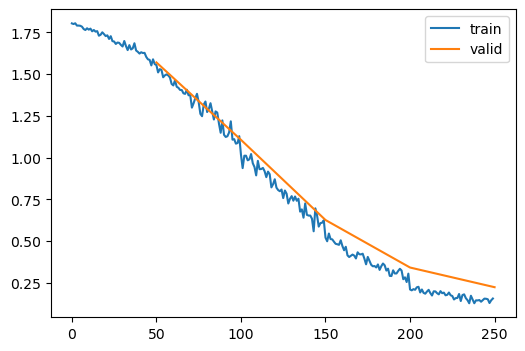

accuracy,loss,epoch,train,time
0.419,1.667,0,True,00:01
0.585,1.495,0,False,00:00
0.682,1.201,1,True,00:01
0.728,0.956,1,False,00:00
0.835,0.659,2,True,00:01
0.890,0.510,2,False,00:00
0.957,0.312,3,True,00:01
0.940,0.303,3,False,00:00
0.989,0.152,4,True,00:01
0.957,0.217,4,False,00:00


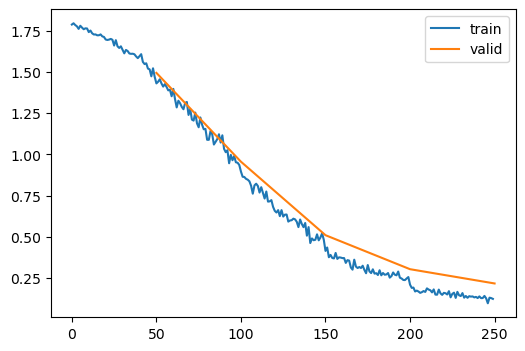

accuracy,loss,epoch,train,time
0.389,1.675,0,True,00:01
0.614,1.511,0,False,00:00
0.721,1.214,1,True,00:01
0.796,0.953,1,False,00:00
0.891,0.630,2,True,00:01
0.919,0.472,2,False,00:00
0.972,0.273,3,True,00:01
0.955,0.274,3,False,00:00
0.994,0.128,4,True,00:01
0.964,0.198,4,False,00:00


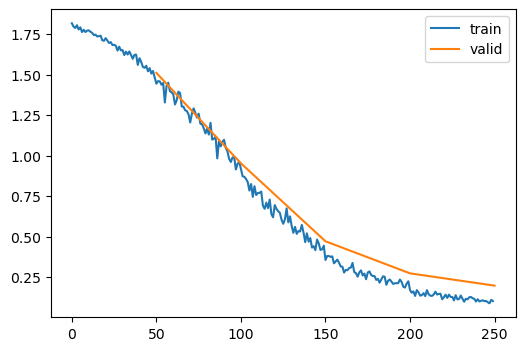

accuracy,loss,epoch,train,time
0.417,1.681,0,True,00:01
0.586,1.528,0,False,00:00
0.652,1.259,1,True,00:01
0.693,1.026,1,False,00:00
0.830,0.716,2,True,00:01
0.893,0.551,2,False,00:00
0.960,0.332,3,True,00:01
0.952,0.313,3,False,00:00
0.992,0.151,4,True,00:01
0.963,0.218,4,False,00:00


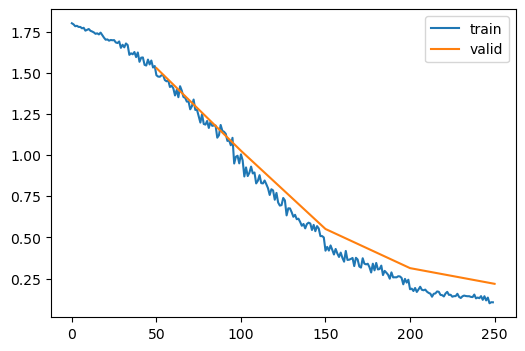

accuracy,loss,epoch,train,time
0.423,1.687,0,True,00:01
0.584,1.545,0,False,00:00
0.675,1.271,1,True,00:01
0.729,1.035,1,False,00:00
0.855,0.698,2,True,00:01
0.892,0.524,2,False,00:00
0.962,0.309,3,True,00:01
0.948,0.303,3,False,00:00
0.991,0.145,4,True,00:01
0.958,0.217,4,False,00:00


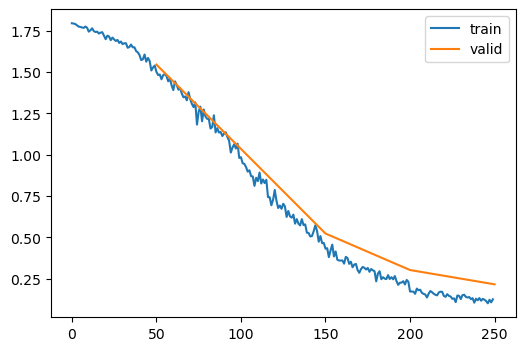

accuracy,loss,epoch,train,time
0.383,1.694,0,True,00:01
0.571,1.551,0,False,00:00
0.659,1.292,1,True,00:01
0.685,1.063,1,False,00:00
0.811,0.753,2,True,00:01
0.873,0.574,2,False,00:00
0.954,0.350,3,True,00:01
0.945,0.323,3,False,00:00
0.989,0.162,4,True,00:01
0.957,0.222,4,False,00:00


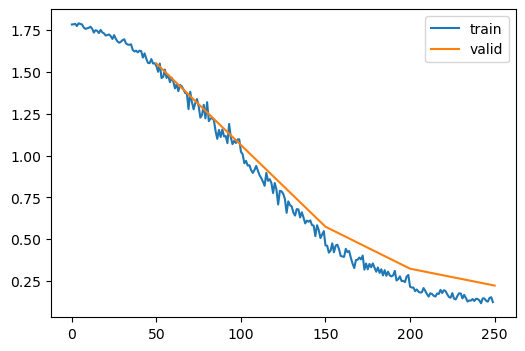

accuracy,loss,epoch,train,time
0.423,1.676,0,True,00:01
0.592,1.516,0,False,00:00
0.681,1.260,1,True,00:01
0.735,1.046,1,False,00:00
0.852,0.735,2,True,00:01
0.899,0.554,2,False,00:00
0.963,0.325,3,True,00:01
0.949,0.305,3,False,00:00
0.993,0.144,4,True,00:01
0.960,0.213,4,False,00:00


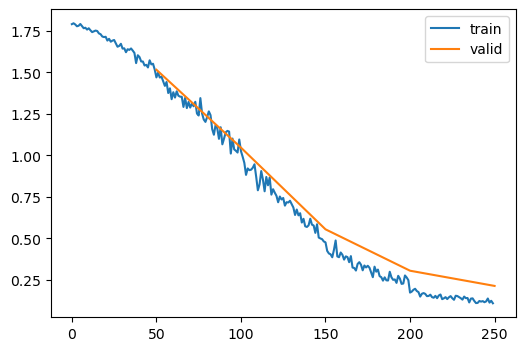

accuracy,loss,epoch,train,time
0.396,1.680,0,True,00:01
0.582,1.518,0,False,00:00
0.677,1.262,1,True,00:01
0.720,1.050,1,False,00:00
0.829,0.753,2,True,00:01
0.873,0.585,2,False,00:00
0.958,0.355,3,True,00:01
0.945,0.324,3,False,00:00
0.992,0.159,4,True,00:01
0.961,0.218,4,False,00:00


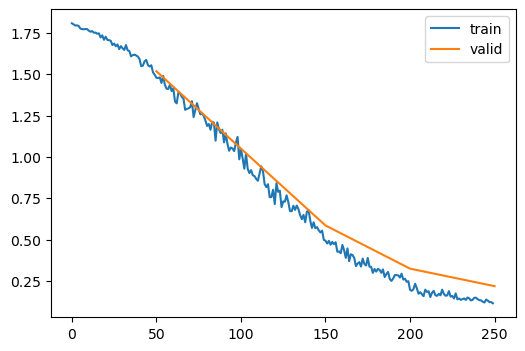

accuracy,loss,epoch,train,time
0.390,1.708,0,True,00:01
0.551,1.578,0,False,00:00
0.661,1.332,1,True,00:01
0.725,1.111,1,False,00:00
0.839,0.803,2,True,00:01
0.884,0.611,2,False,00:00
0.957,0.369,3,True,00:01
0.947,0.329,3,False,00:00
0.991,0.166,4,True,00:01
0.956,0.222,4,False,00:00


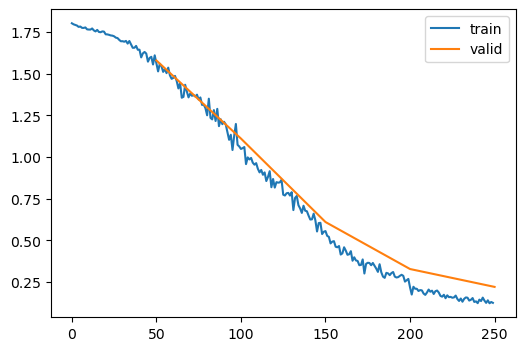

accuracy,loss,epoch,train,time
0.367,1.694,0,True,00:01
0.538,1.551,0,False,00:00
0.659,1.291,1,True,00:01
0.710,1.075,1,False,00:00
0.821,0.782,2,True,00:01
0.874,0.610,2,False,00:00
0.949,0.371,3,True,00:01
0.945,0.336,3,False,00:00
0.989,0.166,4,True,00:01
0.955,0.228,4,False,00:00


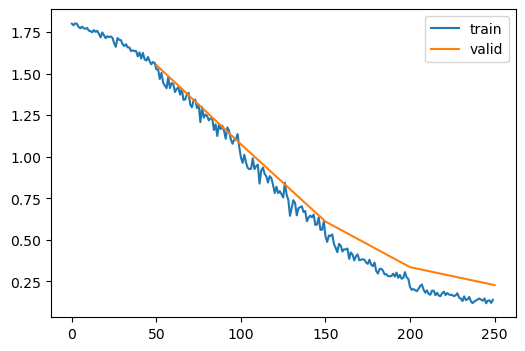

Making inference on test data


accuracy,loss,epoch,train,time
0.750,0.421,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.279,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.466,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.284,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.291,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.414,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.399,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.410,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.384,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.326,0,False,00:00


0.833

In [54]:
ensemble_model(nlearn)

After training 5 epochs with 89% accuracy, the model got 66.7% accuracy.

In [55]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.563,6.725,0,True,00:01
0.776,0.626,0,False,00:01
0.811,0.537,1,True,00:01
0.840,0.475,1,False,00:00
0.902,0.282,2,True,00:01
0.902,0.292,2,False,00:00
0.972,0.095,3,True,00:01
0.911,0.264,3,False,00:00
0.992,0.038,4,True,00:01
0.922,0.220,4,False,00:00


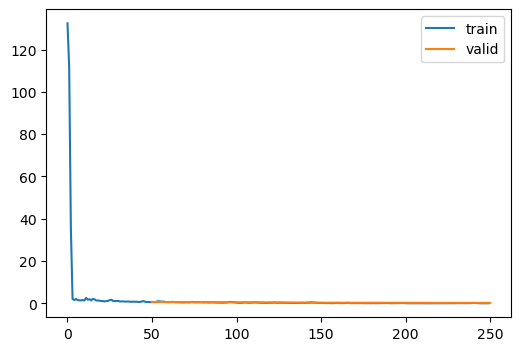

In [56]:
learn = TrainLearner(model, dls, lr=.1, loss_func=F.cross_entropy, cbs=cbs)
learn.fit(5)

Improving the model with parameter initialization, lr_scheduler, and optimizer.

In [57]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

In [58]:
lr, epochs = 6e-3, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
# learn.fit(epochs)

In [59]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.167,2.632,0,False,00:00


In [60]:
def get_model(): return nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)

Training models


accuracy,loss,epoch,train,time
0.737,0.760,0,True,00:02
0.864,0.362,0,False,00:00
0.958,0.126,1,True,00:01
0.894,0.277,1,False,00:00


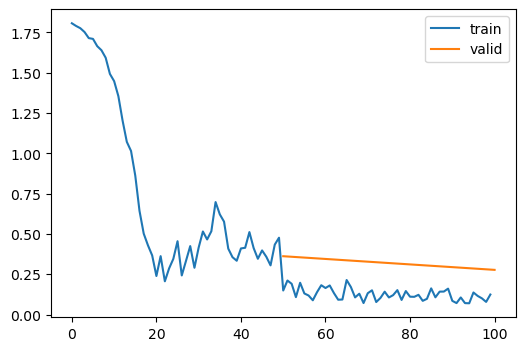

accuracy,loss,epoch,train,time
0.747,0.776,0,True,00:01
0.866,0.369,0,False,00:00
0.957,0.124,1,True,00:01
0.903,0.279,1,False,00:00


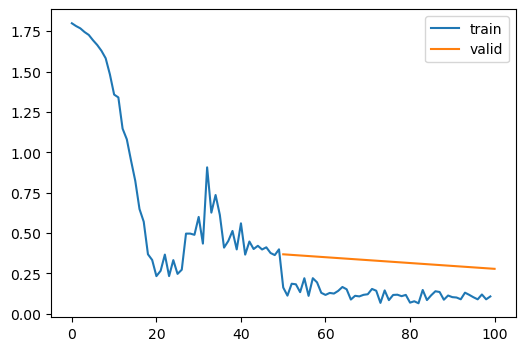

accuracy,loss,epoch,train,time
0.751,0.784,0,True,00:01
0.862,0.363,0,False,00:00
0.957,0.123,1,True,00:01
0.895,0.297,1,False,00:00


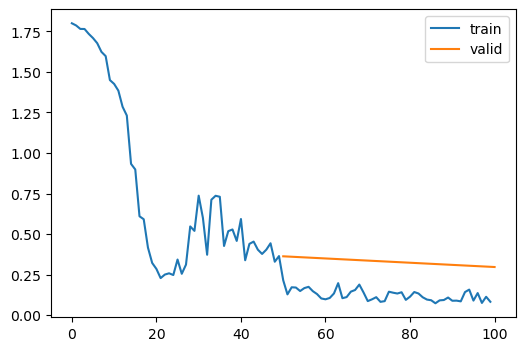

accuracy,loss,epoch,train,time
0.733,0.762,0,True,00:01
0.870,0.343,0,False,00:00
0.962,0.114,1,True,00:02
0.904,0.274,1,False,00:00


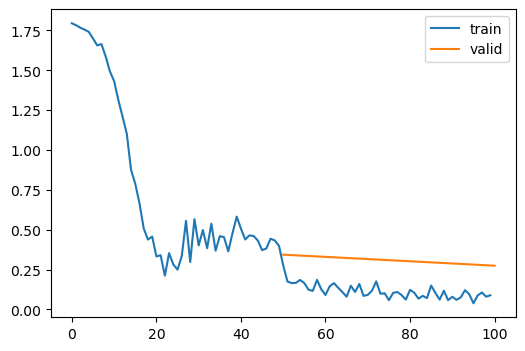

accuracy,loss,epoch,train,time
0.733,0.778,0,True,00:01
0.872,0.341,0,False,00:00
0.962,0.111,1,True,00:01
0.898,0.293,1,False,00:00


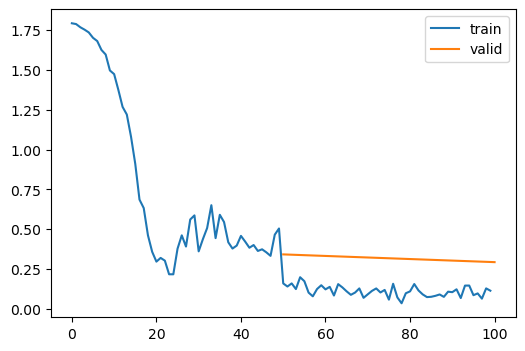

accuracy,loss,epoch,train,time
0.741,0.752,0,True,00:01
0.866,0.364,0,False,00:00
0.959,0.118,1,True,00:01
0.892,0.313,1,False,00:00


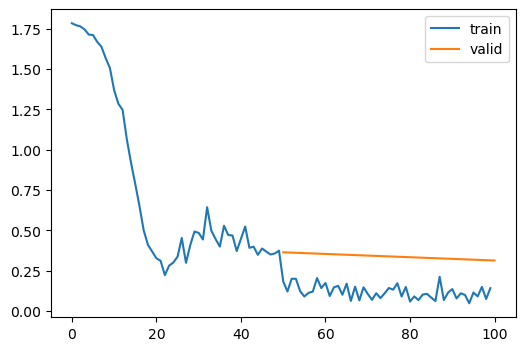

accuracy,loss,epoch,train,time
0.747,0.811,0,True,00:01
0.861,0.387,0,False,00:00
0.955,0.136,1,True,00:01
0.896,0.297,1,False,00:00


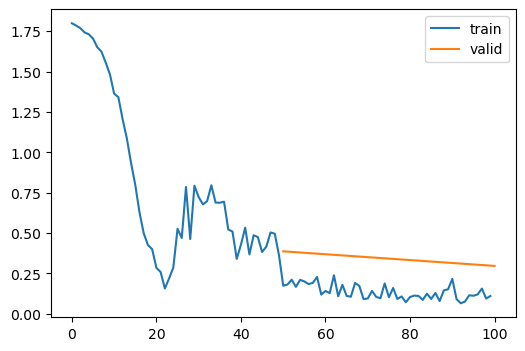

accuracy,loss,epoch,train,time
0.749,0.785,0,True,00:01
0.860,0.364,0,False,00:00
0.959,0.123,1,True,00:01
0.893,0.298,1,False,00:00


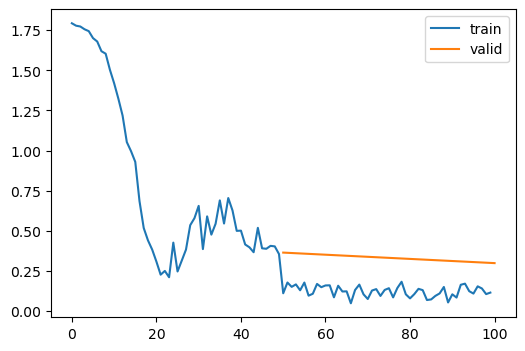

accuracy,loss,epoch,train,time
0.729,0.761,0,True,00:01
0.877,0.345,0,False,00:00
0.961,0.111,1,True,00:02
0.896,0.301,1,False,00:00


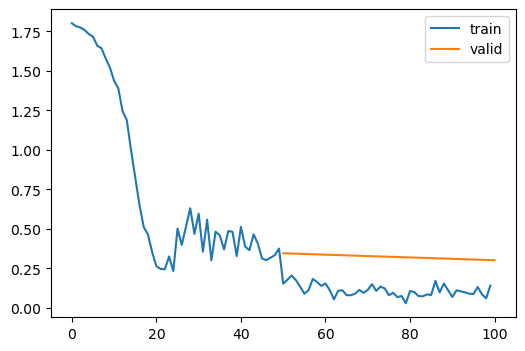

accuracy,loss,epoch,train,time
0.728,0.794,0,True,00:01
0.860,0.389,0,False,00:00
0.958,0.123,1,True,00:01
0.891,0.306,1,False,00:00


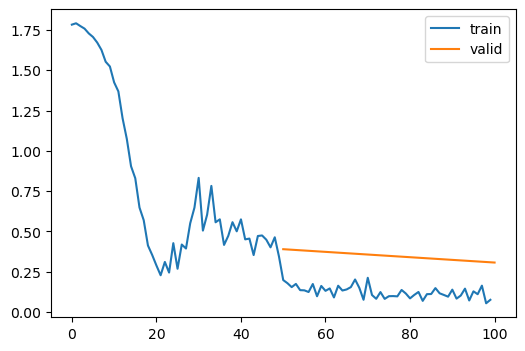

Making inference on test data


accuracy,loss,epoch,train,time
0.917,0.208,0,False,00:00


accuracy,loss,epoch,train,time
0.667,0.791,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.423,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.959,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.446,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.609,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.549,0,False,00:00


accuracy,loss,epoch,train,time
0.750,1.485,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.460,0,False,00:00


accuracy,loss,epoch,train,time
0.750,1.558,0,False,00:00


0.833

In [61]:
lr, epochs = 6e-3, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.731,0.848,0,True,00:01
0.836,0.501,0,False,00:00
0.945,0.159,1,True,00:01
0.895,0.324,1,False,00:00
0.998,0.009,2,True,00:01
0.898,0.317,2,False,00:00


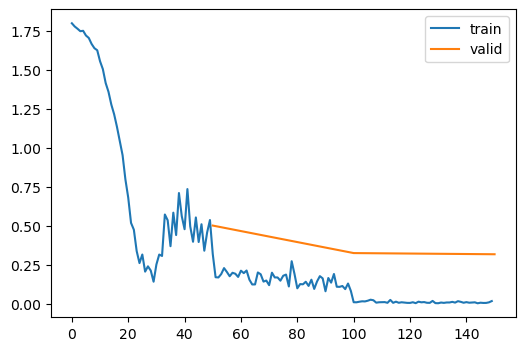

accuracy,loss,epoch,train,time
0.708,0.845,0,True,00:01
0.855,0.407,0,False,00:00
0.950,0.146,1,True,00:02
0.899,0.283,1,False,00:00
0.997,0.013,2,True,00:02
0.902,0.289,2,False,00:00


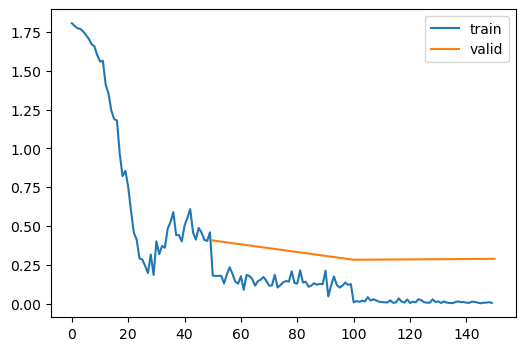

accuracy,loss,epoch,train,time
0.708,0.849,0,True,00:01
0.856,0.408,0,False,00:00
0.944,0.175,1,True,00:02
0.902,0.276,1,False,00:00
0.997,0.014,2,True,00:02
0.900,0.294,2,False,00:00


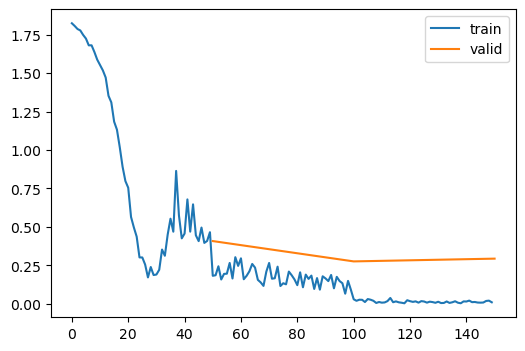

accuracy,loss,epoch,train,time
0.730,0.840,0,True,00:01
0.847,0.434,0,False,00:00
0.944,0.163,1,True,00:02
0.905,0.280,1,False,00:00
0.997,0.014,2,True,00:01
0.909,0.278,2,False,00:00


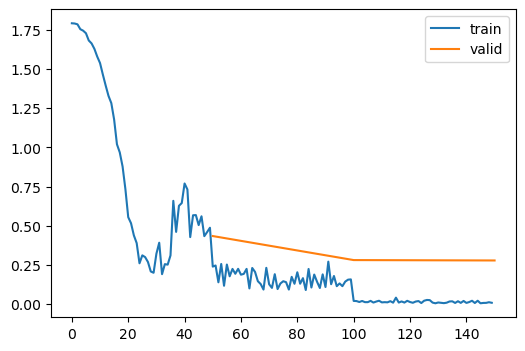

accuracy,loss,epoch,train,time
0.745,0.835,0,True,00:02
0.858,0.384,0,False,00:00
0.946,0.167,1,True,00:02
0.902,0.278,1,False,00:00
0.998,0.011,2,True,00:02
0.908,0.271,2,False,00:00


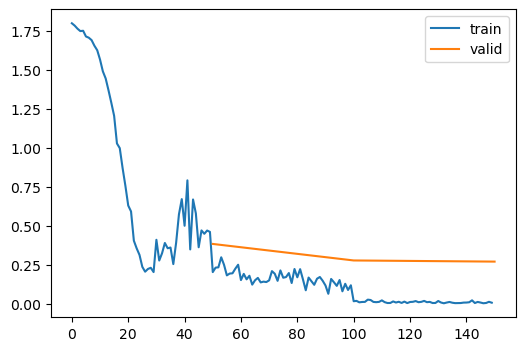

accuracy,loss,epoch,train,time
0.718,0.853,0,True,00:01
0.849,0.411,0,False,00:00
0.941,0.168,1,True,00:02
0.898,0.294,1,False,00:00
0.997,0.014,2,True,00:02
0.899,0.287,2,False,00:00


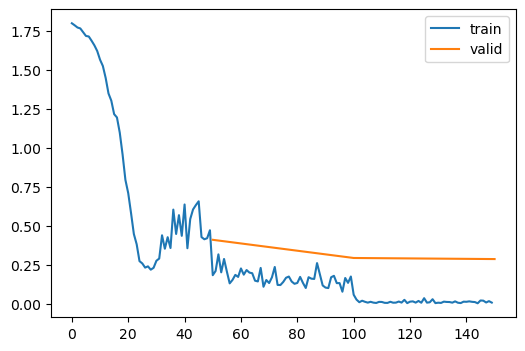

accuracy,loss,epoch,train,time
0.705,0.835,0,True,00:02
0.849,0.410,0,False,00:00
0.945,0.172,1,True,00:02
0.909,0.267,1,False,00:00
0.996,0.017,2,True,00:02
0.907,0.278,2,False,00:00


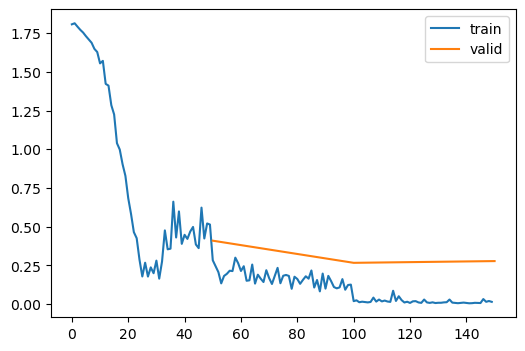

accuracy,loss,epoch,train,time
0.698,0.861,0,True,00:02
0.852,0.404,0,False,00:00
0.945,0.172,1,True,00:02
0.906,0.258,1,False,00:00
0.997,0.014,2,True,00:02
0.911,0.260,2,False,00:00


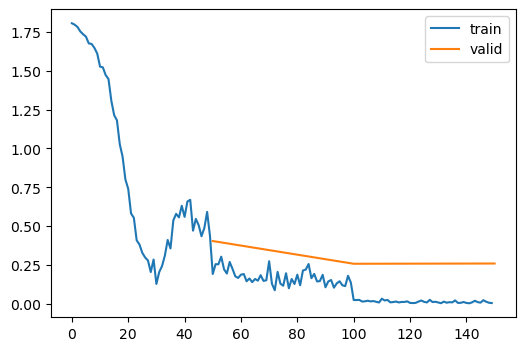

accuracy,loss,epoch,train,time
0.721,0.840,0,True,00:02
0.844,0.426,0,False,00:00
0.944,0.170,1,True,00:02
0.895,0.294,1,False,00:00
0.996,0.017,2,True,00:02
0.910,0.267,2,False,00:00


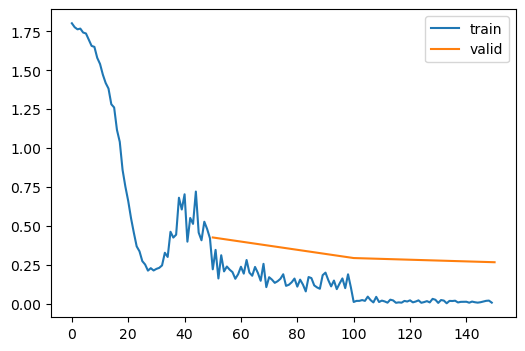

accuracy,loss,epoch,train,time
0.726,0.828,0,True,00:02
0.868,0.383,0,False,00:00
0.947,0.152,1,True,00:02
0.909,0.256,1,False,00:00
0.998,0.010,2,True,00:02
0.915,0.249,2,False,00:00


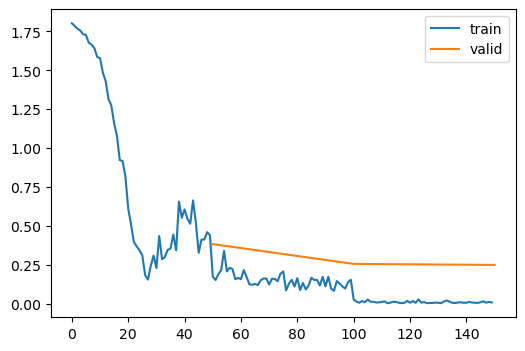

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.487,0,False,00:00


accuracy,loss,epoch,train,time
0.833,1.366,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.803,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.159,0,False,00:00


accuracy,loss,epoch,train,time
0.750,1.561,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.406,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.796,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.731,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.933,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.986,0,False,00:00


0.833

In [62]:
lr, epochs = 6e-3, 3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.704,0.880,0,True,00:02
0.864,0.462,0,False,00:00
0.930,0.218,1,True,00:02
0.891,0.307,1,False,00:00
0.992,0.025,2,True,00:02
0.914,0.286,2,False,00:00
1.000,0.002,3,True,00:02
0.913,0.284,3,False,00:00


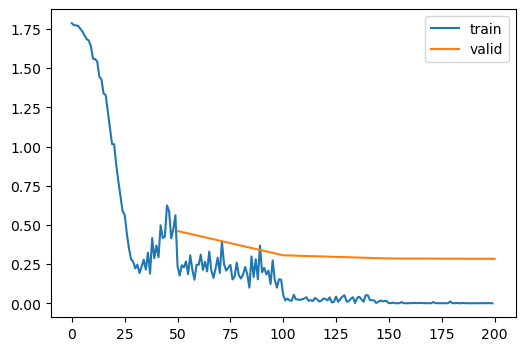

accuracy,loss,epoch,train,time
0.727,0.867,0,True,00:01
0.866,0.424,0,False,00:00
0.934,0.195,1,True,00:02
0.893,0.312,1,False,00:00
0.993,0.024,2,True,00:02
0.908,0.303,2,False,00:00
1.000,0.002,3,True,00:02
0.909,0.305,3,False,00:00


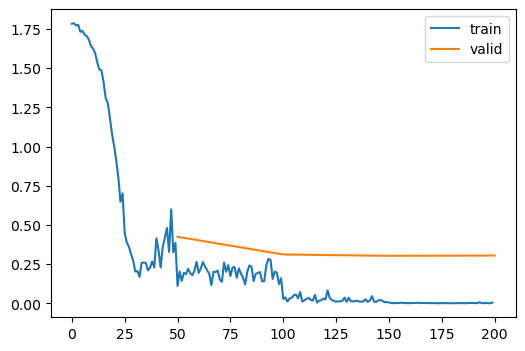

accuracy,loss,epoch,train,time
0.727,0.879,0,True,00:02
0.826,0.530,0,False,00:00
0.931,0.205,1,True,00:01
0.896,0.293,1,False,00:00
0.994,0.023,2,True,00:02
0.907,0.318,2,False,00:00
1.000,0.002,3,True,00:02
0.908,0.316,3,False,00:00


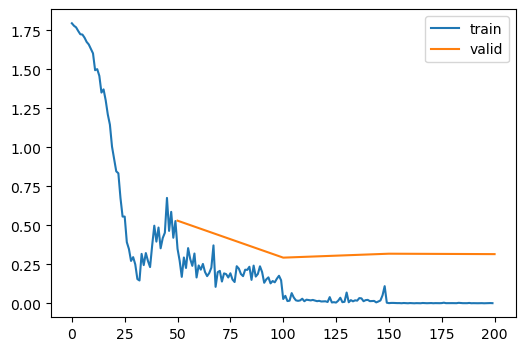

accuracy,loss,epoch,train,time
0.720,0.864,0,True,00:02
0.867,0.487,0,False,00:00
0.926,0.221,1,True,00:02
0.899,0.293,1,False,00:00
0.993,0.024,2,True,00:02
0.908,0.293,2,False,00:00
1.000,0.002,3,True,00:02
0.908,0.284,3,False,00:00


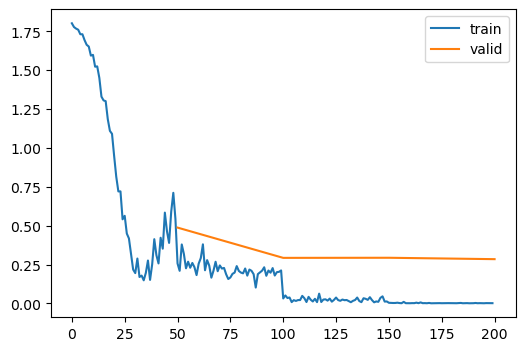

accuracy,loss,epoch,train,time
0.708,0.885,0,True,00:01
0.856,0.444,0,False,00:00
0.927,0.207,1,True,00:02
0.900,0.274,1,False,00:00
0.995,0.017,2,True,00:02
0.908,0.298,2,False,00:00
1.000,0.002,3,True,00:02
0.907,0.318,3,False,00:00


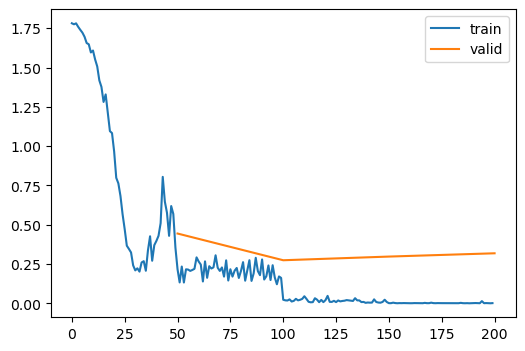

accuracy,loss,epoch,train,time
0.691,0.898,0,True,00:01
0.846,0.519,0,False,00:00
0.922,0.226,1,True,00:02
0.897,0.317,1,False,00:00
0.992,0.024,2,True,00:02
0.904,0.320,2,False,00:00
1.000,0.002,3,True,00:02
0.904,0.327,3,False,00:00


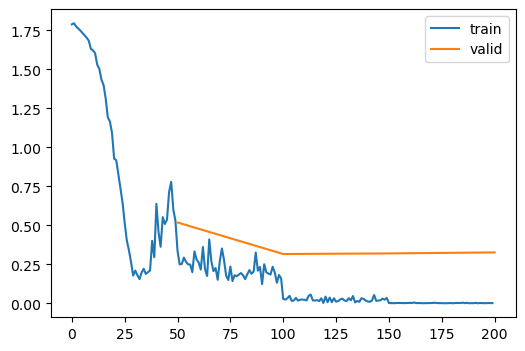

accuracy,loss,epoch,train,time
0.720,0.854,0,True,00:02
0.867,0.433,0,False,00:00
0.933,0.200,1,True,00:01
0.895,0.279,1,False,00:00
0.994,0.021,2,True,00:02
0.909,0.274,2,False,00:00
1.000,0.002,3,True,00:02
0.911,0.273,3,False,00:00


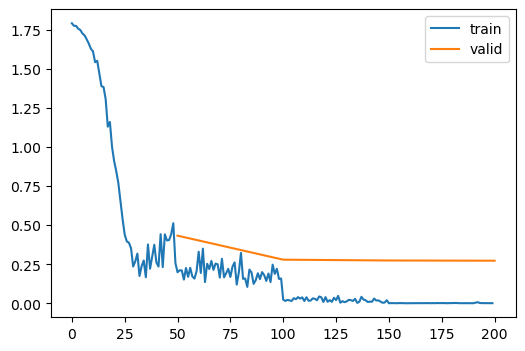

accuracy,loss,epoch,train,time
0.706,0.869,0,True,00:01
0.869,0.411,0,False,00:00
0.932,0.196,1,True,00:02
0.896,0.298,1,False,00:00
0.995,0.019,2,True,00:01
0.904,0.313,2,False,00:00
1.000,0.001,3,True,00:02
0.906,0.325,3,False,00:00


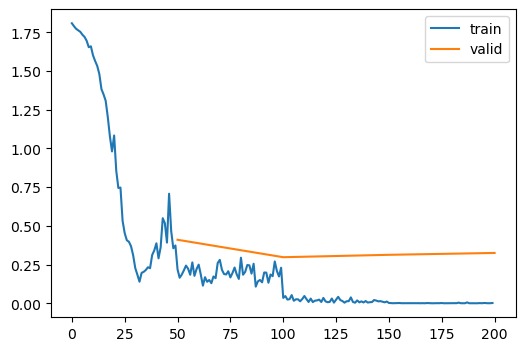

accuracy,loss,epoch,train,time
0.727,0.879,0,True,00:02
0.836,0.555,0,False,00:00
0.931,0.203,1,True,00:02
0.903,0.286,1,False,00:00
0.995,0.017,2,True,00:01
0.907,0.314,2,False,00:00
1.000,0.002,3,True,00:02
0.909,0.304,3,False,00:00


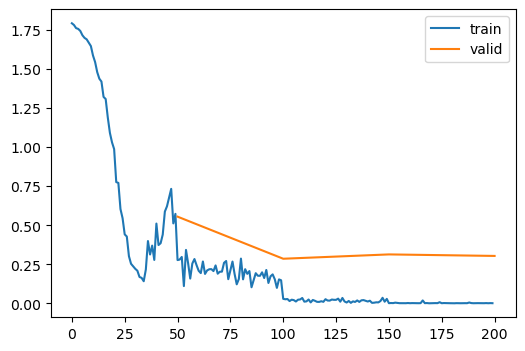

accuracy,loss,epoch,train,time
0.712,0.884,0,True,00:01
0.856,0.534,0,False,00:00
0.923,0.236,1,True,00:02
0.898,0.288,1,False,00:00
0.994,0.020,2,True,00:02
0.906,0.290,2,False,00:00
1.000,0.002,3,True,00:01
0.907,0.292,3,False,00:00


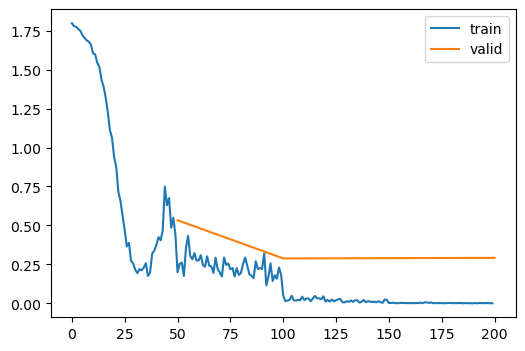

Making inference on test data


accuracy,loss,epoch,train,time
0.917,0.333,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.812,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.598,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.664,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.568,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.491,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.678,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.447,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.464,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.754,0,False,00:00


0.833

In [63]:
lr, epochs = 6e-3, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

We train with a lower learning rate.

accuracy,loss,epoch,train,time
0.328,1.800,0,True,00:02
0.628,1.016,0,False,00:00
0.908,0.369,1,True,00:01
0.846,0.423,1,False,00:00
0.999,0.034,2,True,00:02
0.864,0.361,2,False,00:00
1.000,0.014,3,True,00:02
0.871,0.351,3,False,00:00
1.000,0.011,4,True,00:02
0.871,0.349,4,False,00:00


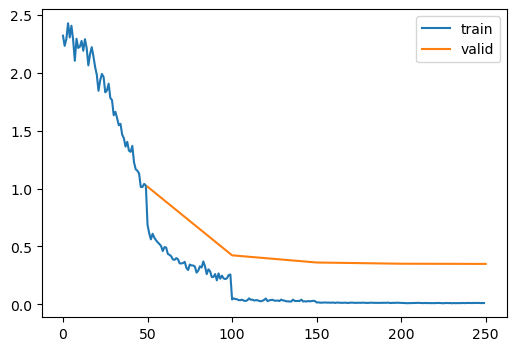

In [64]:
lr, epochs = 6e-4, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [65]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.833,0.380,0,False,00:00


Although the accuracy is very similar, training with lower learning performed much better on the batch data.

Training models


accuracy,loss,epoch,train,time
0.470,1.442,0,True,00:02
0.879,0.562,0,False,00:00
0.969,0.158,1,True,00:02
0.948,0.159,1,False,00:00
1.000,0.010,2,True,00:02
0.949,0.153,2,False,00:00


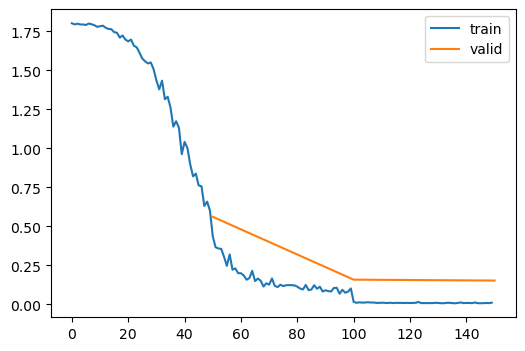

accuracy,loss,epoch,train,time
0.506,1.453,0,True,00:02
0.895,0.547,0,False,00:00
0.971,0.146,1,True,00:02
0.948,0.154,1,False,00:00
1.000,0.009,2,True,00:01
0.950,0.149,2,False,00:00


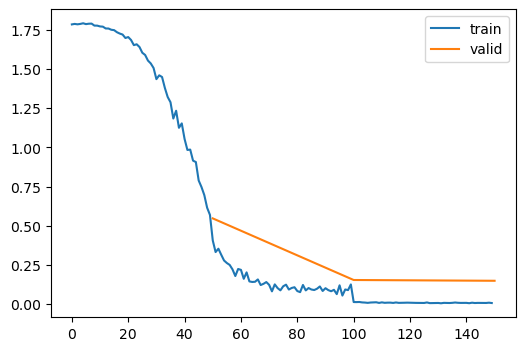

accuracy,loss,epoch,train,time
0.482,1.455,0,True,00:02
0.856,0.587,0,False,00:00
0.967,0.167,1,True,00:02
0.942,0.169,1,False,00:00
1.000,0.011,2,True,00:01
0.943,0.165,2,False,00:00


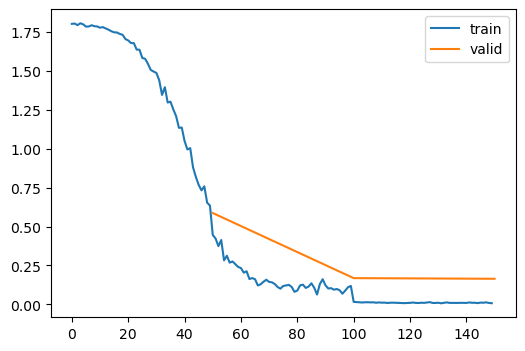

accuracy,loss,epoch,train,time
0.513,1.434,0,True,00:02
0.876,0.548,0,False,00:00
0.971,0.153,1,True,00:01
0.952,0.162,1,False,00:00
1.000,0.011,2,True,00:02
0.950,0.157,2,False,00:00


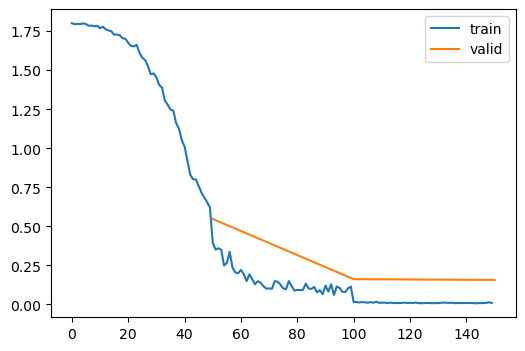

accuracy,loss,epoch,train,time
0.495,1.443,0,True,00:01
0.883,0.554,0,False,00:00
0.971,0.153,1,True,00:02
0.950,0.161,1,False,00:00
1.000,0.011,2,True,00:01
0.946,0.160,2,False,00:00


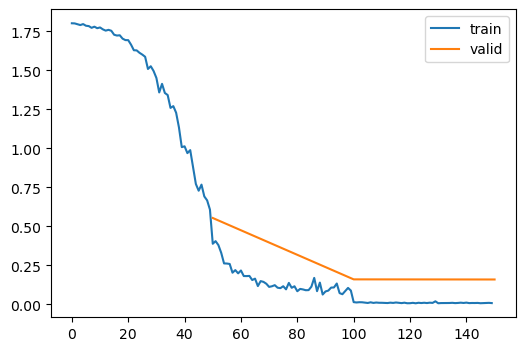

accuracy,loss,epoch,train,time
0.466,1.448,0,True,00:02
0.877,0.545,0,False,00:00
0.971,0.151,1,True,00:02
0.947,0.158,1,False,00:00
1.000,0.010,2,True,00:01
0.948,0.154,2,False,00:00


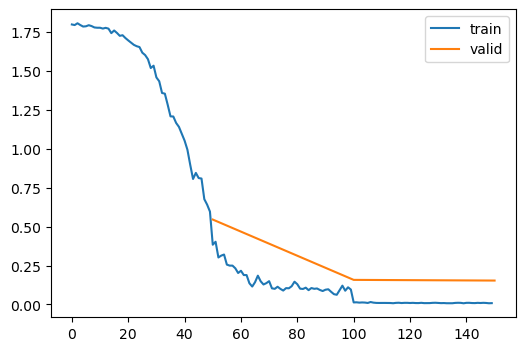

accuracy,loss,epoch,train,time
0.496,1.433,0,True,00:01
0.881,0.523,0,False,00:00
0.973,0.142,1,True,00:01
0.951,0.157,1,False,00:00
1.000,0.009,2,True,00:02
0.952,0.151,2,False,00:00


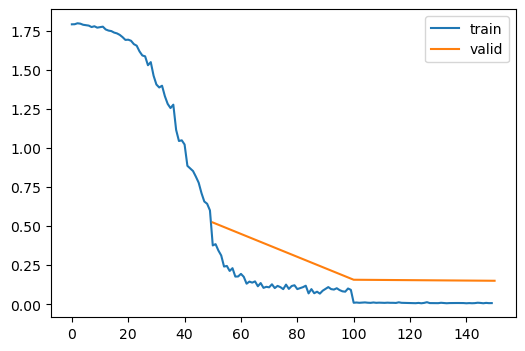

accuracy,loss,epoch,train,time
0.514,1.434,0,True,00:02
0.878,0.570,0,False,00:00
0.970,0.159,1,True,00:02
0.951,0.160,1,False,00:00
1.000,0.010,2,True,00:02
0.950,0.151,2,False,00:00


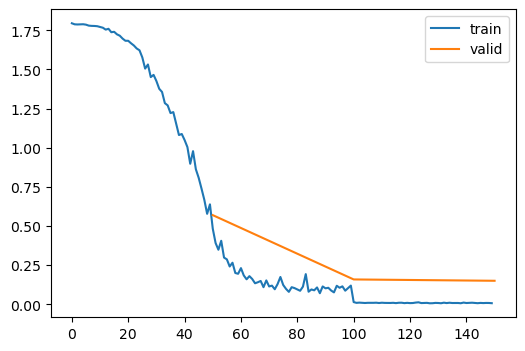

accuracy,loss,epoch,train,time
0.496,1.446,0,True,00:02
0.866,0.554,0,False,00:00
0.969,0.158,1,True,00:02
0.951,0.156,1,False,00:00
1.000,0.010,2,True,00:02
0.950,0.154,2,False,00:00


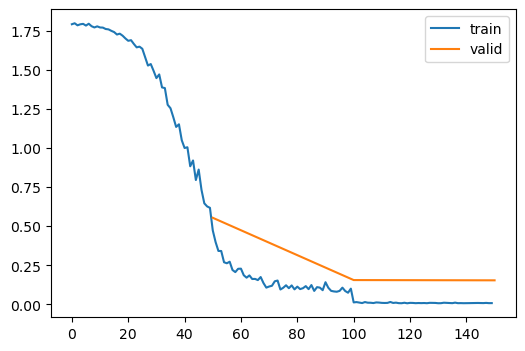

accuracy,loss,epoch,train,time
0.493,1.452,0,True,00:02
0.895,0.559,0,False,00:01
0.973,0.148,1,True,00:01
0.944,0.168,1,False,00:00
1.000,0.009,2,True,00:01
0.947,0.159,2,False,00:00


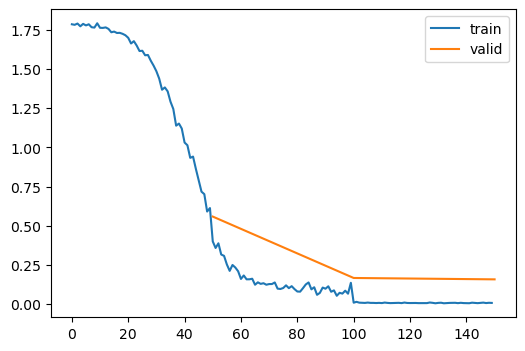

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.400,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.360,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.558,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.266,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.392,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.410,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.218,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.546,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.392,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.491,0,False,00:00


0.833

In [66]:
lr, epochs = 6e-4, 3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.459,1.568,0,True,00:01
0.778,0.869,0,False,00:00
0.956,0.223,1,True,00:02
0.941,0.169,1,False,00:00
0.999,0.009,2,True,00:02
0.942,0.166,2,False,00:00
1.000,0.004,3,True,00:01
0.942,0.167,3,False,00:00


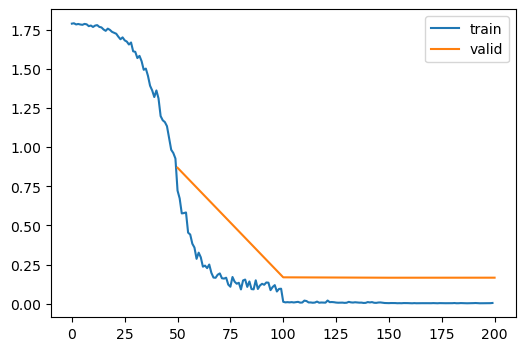

accuracy,loss,epoch,train,time
0.462,1.541,0,True,00:01
0.814,0.797,0,False,00:00
0.960,0.203,1,True,00:01
0.942,0.171,1,False,00:00
0.999,0.010,2,True,00:01
0.938,0.169,2,False,00:00
1.000,0.004,3,True,00:02
0.941,0.167,3,False,00:00


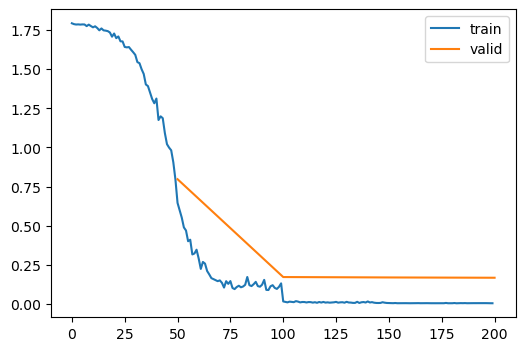

accuracy,loss,epoch,train,time
0.398,1.566,0,True,00:02
0.742,0.883,0,False,00:00
0.951,0.248,1,True,00:02
0.949,0.158,1,False,00:00
0.999,0.011,2,True,00:01
0.945,0.157,2,False,00:00
1.000,0.004,3,True,00:02
0.943,0.161,3,False,00:00


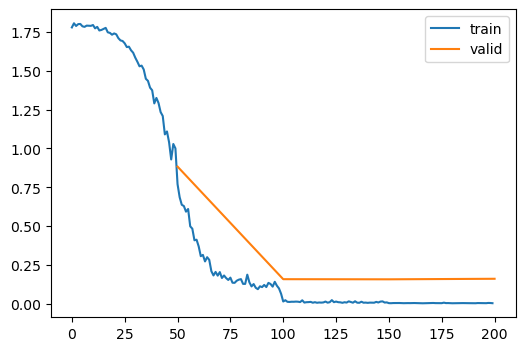

accuracy,loss,epoch,train,time
0.450,1.563,0,True,00:01
0.751,0.888,0,False,00:00
0.951,0.247,1,True,00:01
0.939,0.171,1,False,00:00
0.999,0.009,2,True,00:02
0.940,0.174,2,False,00:00
1.000,0.004,3,True,00:01
0.942,0.171,3,False,00:00


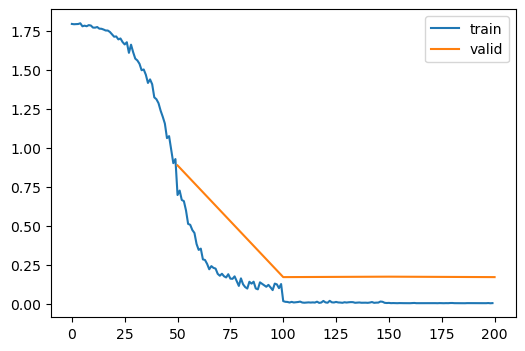

accuracy,loss,epoch,train,time
0.455,1.552,0,True,00:02
0.808,0.833,0,False,00:00
0.953,0.232,1,True,00:02
0.946,0.168,1,False,00:00
1.000,0.010,2,True,00:01
0.943,0.166,2,False,00:00
1.000,0.005,3,True,00:01
0.943,0.166,3,False,00:00


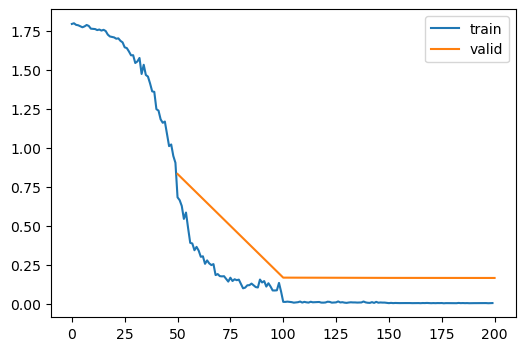

accuracy,loss,epoch,train,time
0.450,1.545,0,True,00:01
0.811,0.824,0,False,00:00
0.954,0.228,1,True,00:02
0.940,0.168,1,False,00:00
0.999,0.010,2,True,00:02
0.941,0.167,2,False,00:00
1.000,0.004,3,True,00:01
0.940,0.166,3,False,00:00


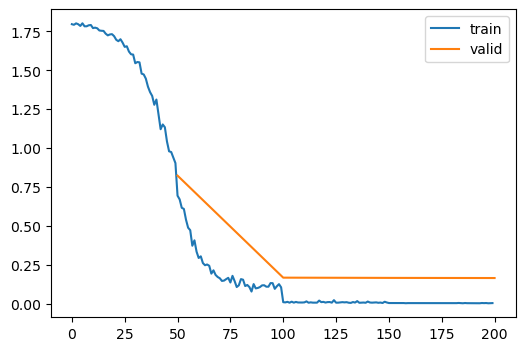

accuracy,loss,epoch,train,time
0.439,1.566,0,True,00:02
0.770,0.869,0,False,00:00
0.952,0.235,1,True,00:01
0.942,0.172,1,False,00:00
0.999,0.011,2,True,00:01
0.939,0.170,2,False,00:00
1.000,0.004,3,True,00:01
0.939,0.171,3,False,00:00


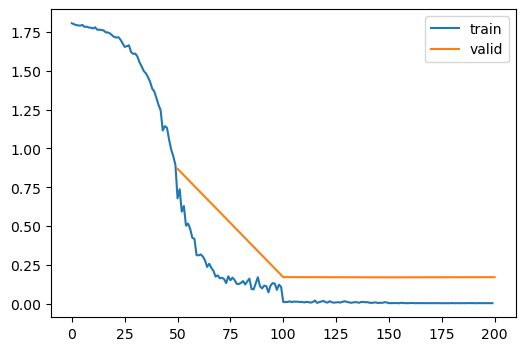

accuracy,loss,epoch,train,time
0.435,1.575,0,True,00:02
0.791,0.855,0,False,00:00
0.953,0.227,1,True,00:01
0.946,0.159,1,False,00:00
0.999,0.009,2,True,00:01
0.942,0.159,2,False,00:00
1.000,0.004,3,True,00:01
0.943,0.158,3,False,00:00


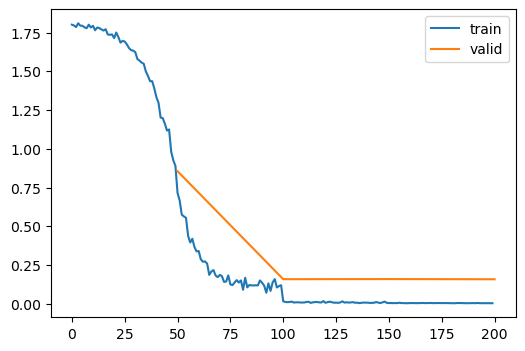

accuracy,loss,epoch,train,time
0.441,1.546,0,True,00:02
0.816,0.836,0,False,00:00
0.955,0.229,1,True,00:02
0.947,0.173,1,False,00:00
0.999,0.011,2,True,00:02
0.944,0.165,2,False,00:00
1.000,0.004,3,True,00:01
0.943,0.165,3,False,00:00


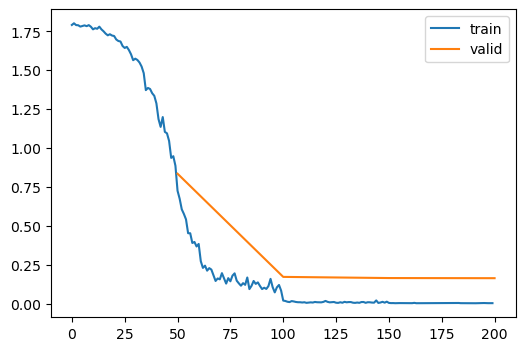

accuracy,loss,epoch,train,time
0.443,1.546,0,True,00:01
0.804,0.816,0,False,00:00
0.960,0.212,1,True,00:02
0.947,0.162,1,False,00:00
0.999,0.010,2,True,00:02
0.940,0.161,2,False,00:00
1.000,0.004,3,True,00:02
0.941,0.160,3,False,00:00


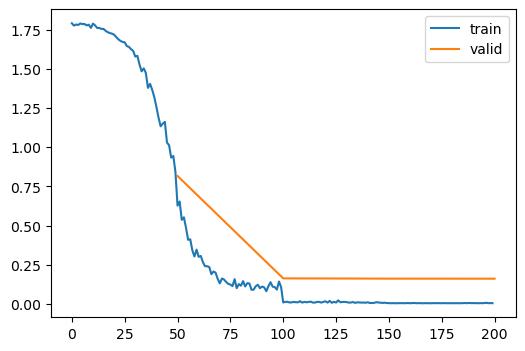

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.329,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.361,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.698,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.292,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.379,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.335,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.529,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.256,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.247,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.725,0,False,00:00


0.833

In [67]:
lr, epochs = 6e-4, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.405,1.617,0,True,00:02
0.740,1.102,0,False,00:00
0.941,0.320,1,True,00:02
0.950,0.160,1,False,00:00
0.997,0.015,2,True,00:01
0.946,0.162,2,False,00:00
1.000,0.003,3,True,00:02
0.948,0.164,3,False,00:00
1.000,0.002,4,True,00:01
0.947,0.164,4,False,00:00


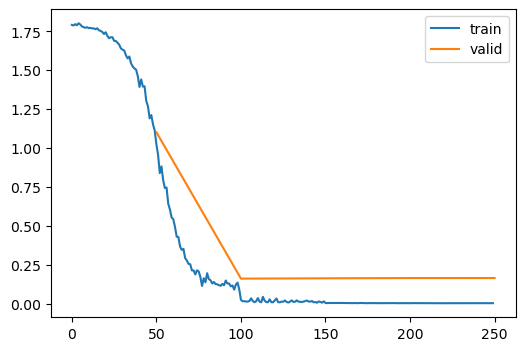

accuracy,loss,epoch,train,time
0.409,1.643,0,True,00:02
0.669,1.171,0,False,00:00
0.925,0.349,1,True,00:01
0.946,0.173,1,False,00:00
0.997,0.016,2,True,00:01
0.937,0.173,2,False,00:00
1.000,0.003,3,True,00:01
0.940,0.172,3,False,00:00
1.000,0.002,4,True,00:01
0.941,0.172,4,False,00:00


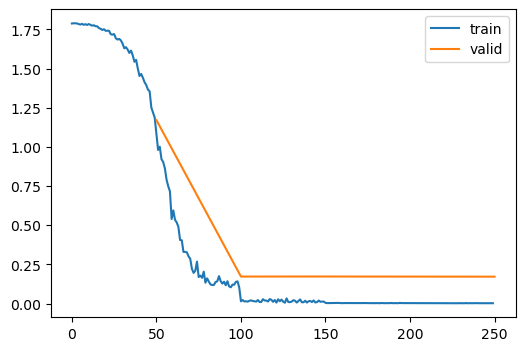

accuracy,loss,epoch,train,time
0.380,1.630,0,True,00:01
0.729,1.096,0,False,00:00
0.937,0.320,1,True,00:02
0.942,0.168,1,False,00:00
0.996,0.016,2,True,00:01
0.942,0.163,2,False,00:00
1.000,0.003,3,True,00:01
0.938,0.166,3,False,00:01
1.000,0.003,4,True,00:01
0.938,0.165,4,False,00:00


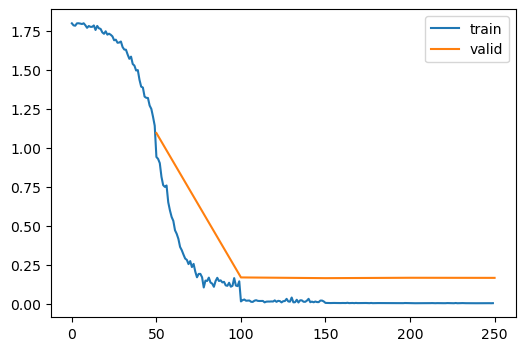

accuracy,loss,epoch,train,time
0.412,1.615,0,True,00:02
0.721,1.095,0,False,00:00
0.934,0.343,1,True,00:02
0.943,0.165,1,False,00:00
0.996,0.019,2,True,00:02
0.941,0.168,2,False,00:00
1.000,0.004,3,True,00:02
0.943,0.165,3,False,00:00
1.000,0.003,4,True,00:02
0.942,0.165,4,False,00:00


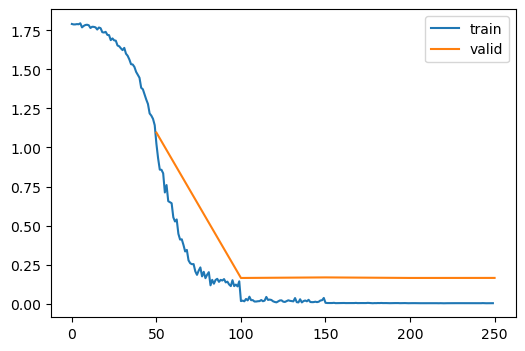

accuracy,loss,epoch,train,time
0.377,1.652,0,True,00:01
0.746,1.195,0,False,00:00
0.933,0.363,1,True,00:02
0.949,0.162,1,False,00:00
0.997,0.017,2,True,00:02
0.943,0.170,2,False,00:00
1.000,0.003,3,True,00:01
0.942,0.166,3,False,00:00
1.000,0.002,4,True,00:01
0.942,0.166,4,False,00:00


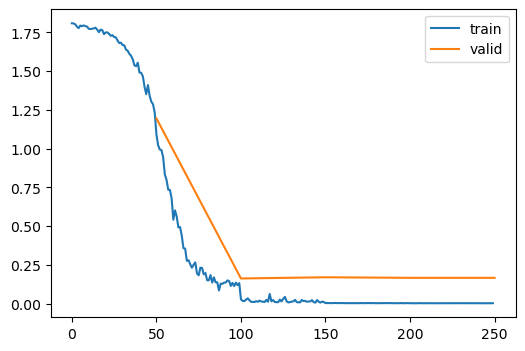

accuracy,loss,epoch,train,time
0.439,1.608,0,True,00:02
0.682,1.087,0,False,00:00
0.924,0.345,1,True,00:02
0.945,0.168,1,False,00:00
0.996,0.016,2,True,00:02
0.938,0.178,2,False,00:00
1.000,0.003,3,True,00:02
0.939,0.176,3,False,00:00
1.000,0.003,4,True,00:02
0.939,0.176,4,False,00:00


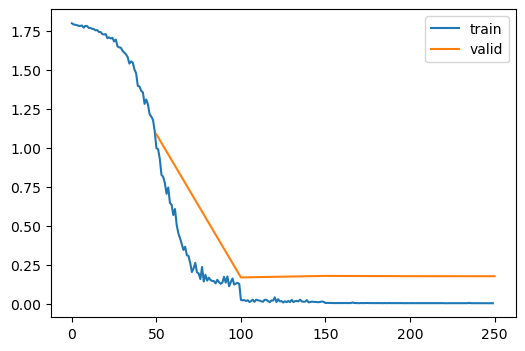

accuracy,loss,epoch,train,time
0.414,1.636,0,True,00:02
0.638,1.163,0,False,00:00
0.924,0.351,1,True,00:01
0.942,0.171,1,False,00:00
0.997,0.017,2,True,00:01
0.941,0.172,2,False,00:00
1.000,0.003,3,True,00:02
0.942,0.172,3,False,00:00
1.000,0.003,4,True,00:01
0.943,0.171,4,False,00:00


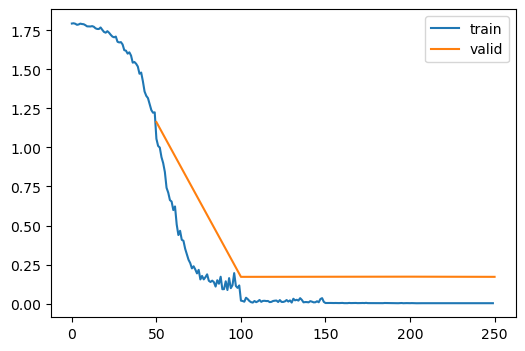

accuracy,loss,epoch,train,time
0.377,1.641,0,True,00:02
0.654,1.150,0,False,00:00
0.926,0.346,1,True,00:01
0.944,0.167,1,False,00:00
0.996,0.018,2,True,00:02
0.934,0.178,2,False,00:00
1.000,0.003,3,True,00:01
0.935,0.173,3,False,00:00
1.000,0.003,4,True,00:01
0.936,0.173,4,False,00:00


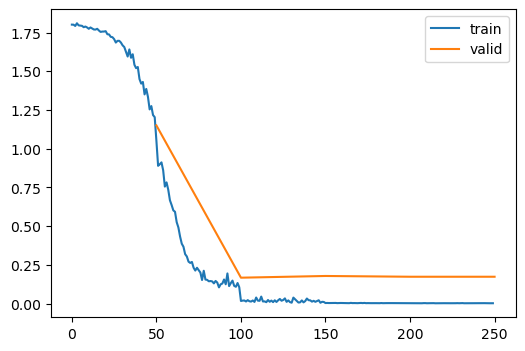

accuracy,loss,epoch,train,time
0.386,1.636,0,True,00:02
0.688,1.138,0,False,00:00
0.929,0.349,1,True,00:02
0.947,0.164,1,False,00:00
0.996,0.018,2,True,00:02
0.942,0.170,2,False,00:00
1.000,0.003,3,True,00:02
0.945,0.166,3,False,00:00
1.000,0.003,4,True,00:02
0.944,0.166,4,False,00:00


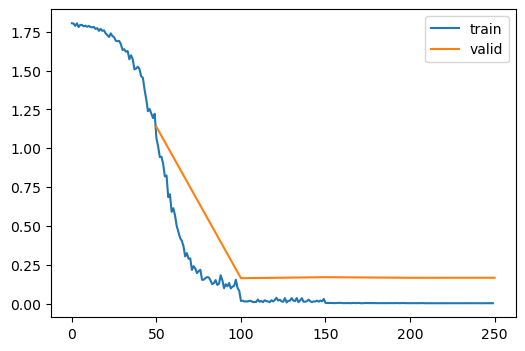

accuracy,loss,epoch,train,time
0.352,1.657,0,True,00:02
0.712,1.166,0,False,00:00
0.937,0.342,1,True,00:02
0.946,0.164,1,False,00:00
0.997,0.014,2,True,00:02
0.942,0.165,2,False,00:00
1.000,0.003,3,True,00:02
0.943,0.167,3,False,00:00
1.000,0.002,4,True,00:01
0.943,0.167,4,False,00:00


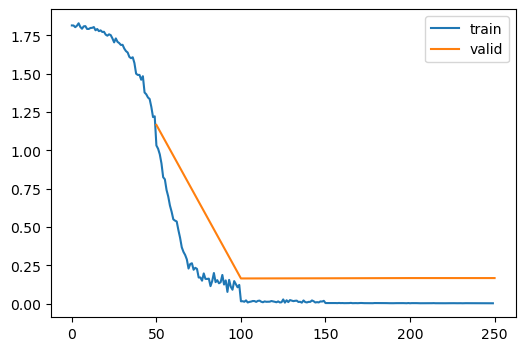

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.552,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.482,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.336,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.464,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.640,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.625,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.213,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.234,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.332,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.271,0,False,00:00


0.833

In [68]:
lr, epochs = 6e-4, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Dropout

accuracy,loss,epoch,train,time
0.237,2.996,0,True,00:02
0.630,0.992,0,False,00:00
0.565,1.240,1,True,00:02
0.856,0.471,1,False,00:00
0.754,0.652,2,True,00:02
0.908,0.321,2,False,00:00
0.828,0.449,3,True,00:02
0.922,0.273,3,False,00:00
0.855,0.389,4,True,00:01
0.924,0.267,4,False,00:00


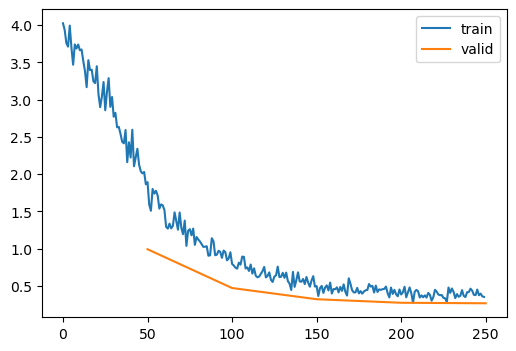

In [69]:
lr, epochs = 1e-3, 5
# set_seed(42)
model = nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 6),
]).apply(init_params)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn1 = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn1.fit(epochs)

In [70]:
learn.dls = DataLoaders(tst_dl, tst_dl)
learn.fit(train=False)

accuracy,loss,epoch,train,time
0.833,0.380,0,False,00:00


In [71]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(9481, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 6),
]).apply(init_params)

Training models


accuracy,loss,epoch,train,time
0.613,1.068,0,True,00:02
0.944,0.174,0,False,00:00
0.983,0.056,1,True,00:02
0.945,0.158,1,False,00:00


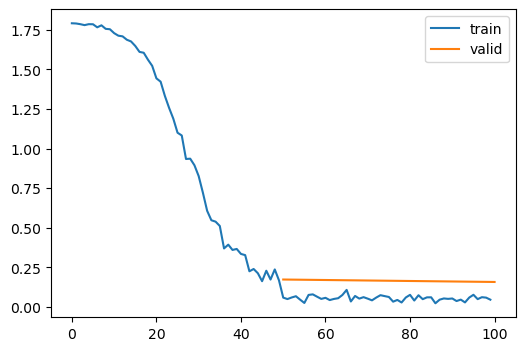

accuracy,loss,epoch,train,time
0.626,1.045,0,True,00:01
0.937,0.186,0,False,00:00
0.981,0.057,1,True,00:01
0.938,0.165,1,False,00:00


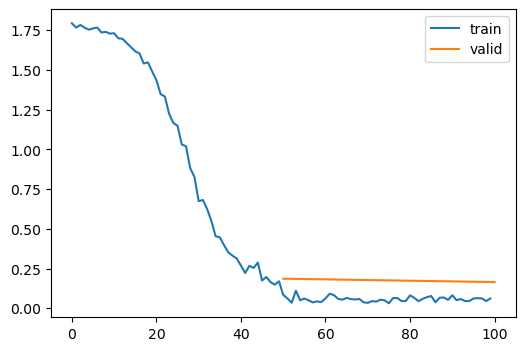

accuracy,loss,epoch,train,time
0.602,1.090,0,True,00:02
0.937,0.204,0,False,00:00
0.981,0.065,1,True,00:02
0.942,0.161,1,False,00:00


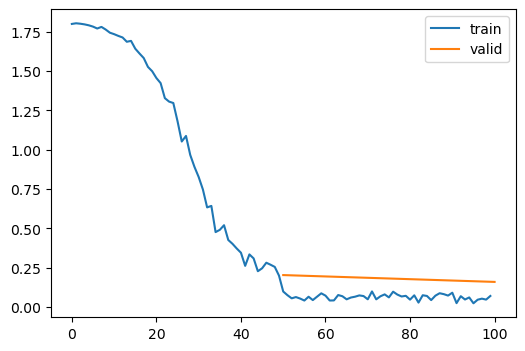

accuracy,loss,epoch,train,time
0.638,1.078,0,True,00:02
0.948,0.173,0,False,00:00
0.984,0.053,1,True,00:02
0.939,0.159,1,False,00:00


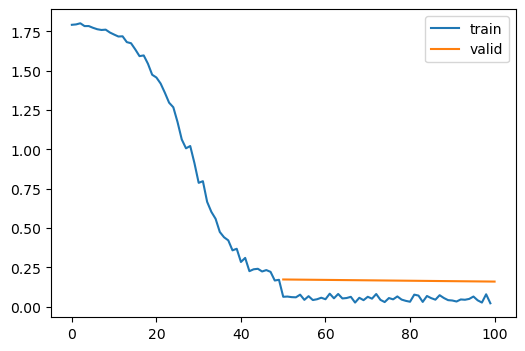

accuracy,loss,epoch,train,time
0.636,1.070,0,True,00:02
0.942,0.185,0,False,00:00
0.984,0.054,1,True,00:01
0.946,0.161,1,False,00:00


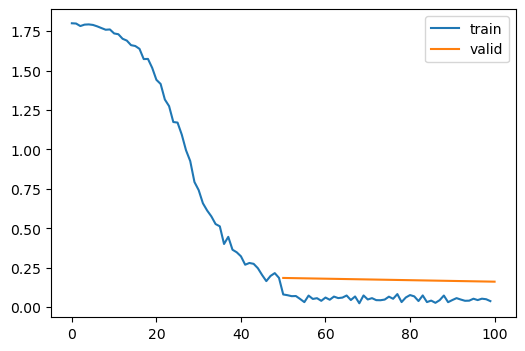

accuracy,loss,epoch,train,time
0.588,1.121,0,True,00:02
0.944,0.186,0,False,00:00
0.984,0.057,1,True,00:02
0.946,0.151,1,False,00:00


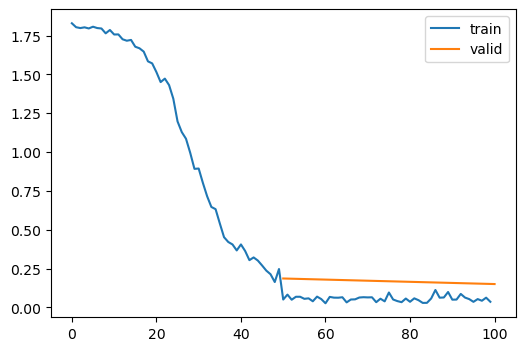

accuracy,loss,epoch,train,time
0.628,1.086,0,True,00:02
0.939,0.190,0,False,00:00
0.984,0.055,1,True,00:02
0.942,0.166,1,False,00:00


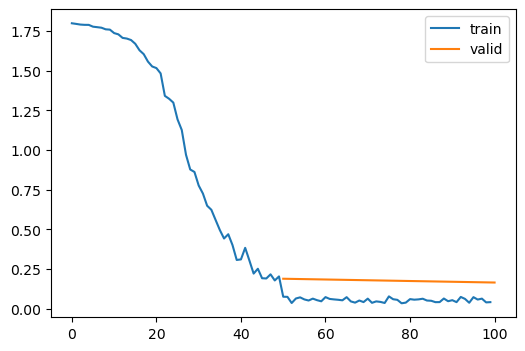

accuracy,loss,epoch,train,time
0.609,1.085,0,True,00:02
0.938,0.186,0,False,00:00
0.983,0.057,1,True,00:01
0.939,0.165,1,False,00:00


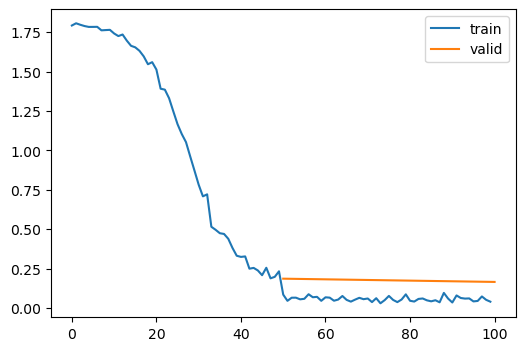

accuracy,loss,epoch,train,time
0.638,1.068,0,True,00:02
0.948,0.166,0,False,00:00
0.981,0.061,1,True,00:01
0.942,0.162,1,False,00:00


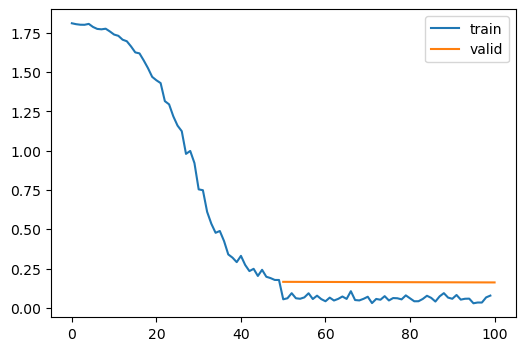

accuracy,loss,epoch,train,time
0.631,1.062,0,True,00:02
0.946,0.173,0,False,00:00
0.984,0.053,1,True,00:02
0.942,0.163,1,False,00:00


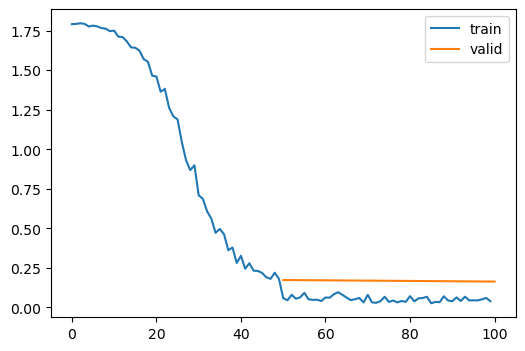

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.519,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.227,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.725,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.289,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.251,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.486,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.463,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.357,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.493,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.598,0,False,00:00


0.833

In [72]:
lr, epochs = 1e-3, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.535,1.294,0,True,00:02
0.939,0.234,0,False,00:00
0.973,0.087,1,True,00:02
0.927,0.202,1,False,00:00
0.999,0.007,2,True,00:02
0.929,0.204,2,False,00:00


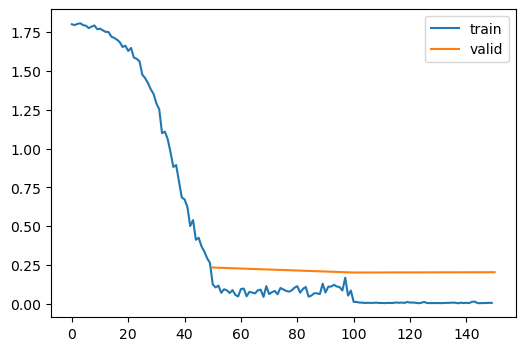

accuracy,loss,epoch,train,time
0.575,1.244,0,True,00:01
0.937,0.233,0,False,00:00
0.971,0.087,1,True,00:02
0.937,0.187,1,False,00:00
1.000,0.007,2,True,00:02
0.933,0.193,2,False,00:00


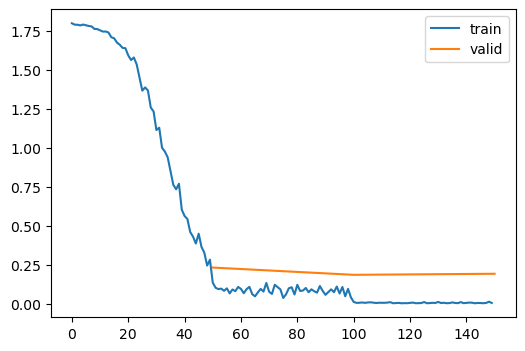

accuracy,loss,epoch,train,time
0.536,1.258,0,True,00:01
0.946,0.222,0,False,00:00
0.971,0.087,1,True,00:02
0.930,0.196,1,False,00:00
1.000,0.007,2,True,00:01
0.932,0.192,2,False,00:00


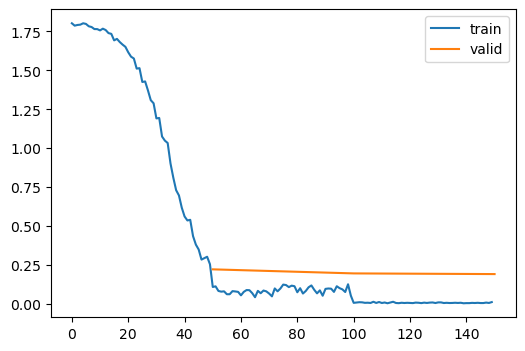

accuracy,loss,epoch,train,time
0.583,1.236,0,True,00:01
0.949,0.198,0,False,00:00
0.971,0.084,1,True,00:01
0.932,0.199,1,False,00:00
0.999,0.009,2,True,00:01
0.931,0.192,2,False,00:00


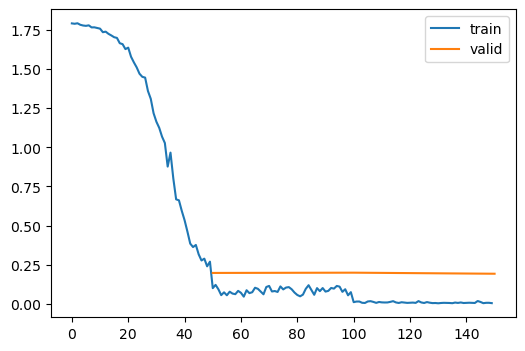

accuracy,loss,epoch,train,time
0.543,1.256,0,True,00:01
0.938,0.224,0,False,00:00
0.971,0.085,1,True,00:01
0.933,0.195,1,False,00:00
1.000,0.007,2,True,00:01
0.934,0.190,2,False,00:00


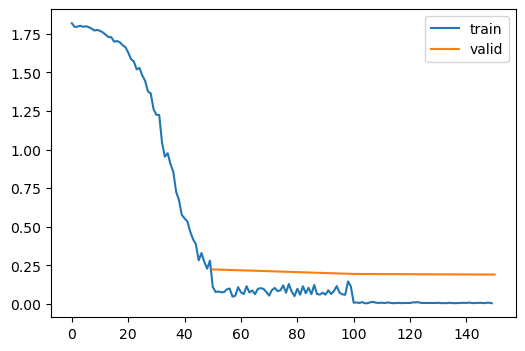

accuracy,loss,epoch,train,time
0.589,1.225,0,True,00:01
0.946,0.209,0,False,00:00
0.974,0.081,1,True,00:01
0.928,0.207,1,False,00:00
0.999,0.008,2,True,00:01
0.932,0.203,2,False,00:00


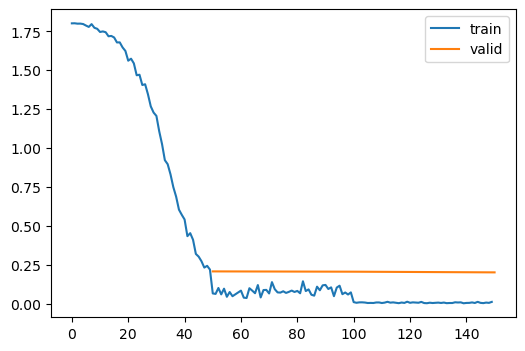

accuracy,loss,epoch,train,time
0.545,1.248,0,True,00:01
0.943,0.217,0,False,00:00
0.971,0.086,1,True,00:01
0.927,0.204,1,False,00:00
1.000,0.007,2,True,00:01
0.929,0.198,2,False,00:00


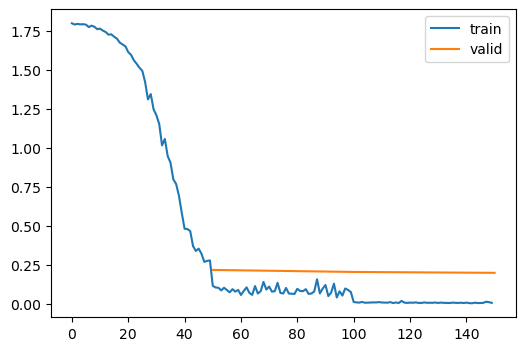

accuracy,loss,epoch,train,time
0.571,1.249,0,True,00:01
0.944,0.213,0,False,00:00
0.974,0.081,1,True,00:01
0.928,0.195,1,False,00:00
0.999,0.006,2,True,00:01
0.931,0.201,2,False,00:00


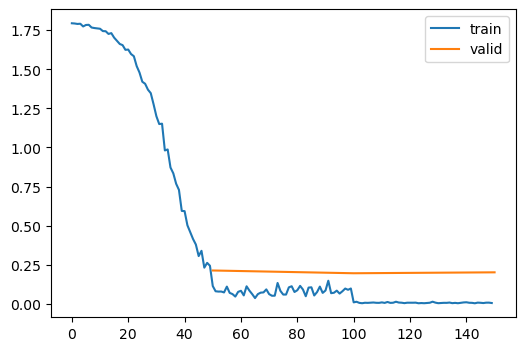

accuracy,loss,epoch,train,time
0.568,1.230,0,True,00:01
0.932,0.208,0,False,00:00
0.973,0.082,1,True,00:01
0.932,0.187,1,False,00:00
0.999,0.007,2,True,00:01
0.931,0.181,2,False,00:00


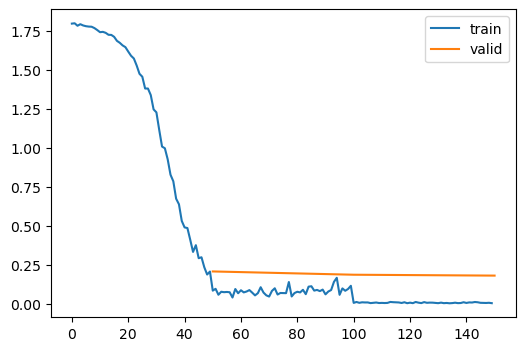

accuracy,loss,epoch,train,time
0.573,1.253,0,True,00:01
0.943,0.212,0,False,00:00
0.970,0.086,1,True,00:01
0.933,0.193,1,False,00:00
0.999,0.007,2,True,00:01
0.931,0.199,2,False,00:00


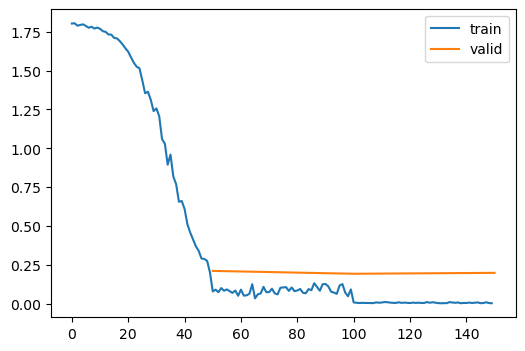

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.344,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.394,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.483,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.714,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.656,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.486,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.296,0,False,00:00


accuracy,loss,epoch,train,time
0.750,0.558,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.194,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.440,0,False,00:00


0.833

In [73]:
lr, epochs = 1e-3, 3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.523,1.383,0,True,00:01
0.929,0.350,0,False,00:00
0.965,0.117,1,True,00:01
0.923,0.220,1,False,00:00
0.996,0.015,2,True,00:01
0.920,0.229,2,False,00:00
1.000,0.003,3,True,00:01
0.920,0.226,3,False,00:00


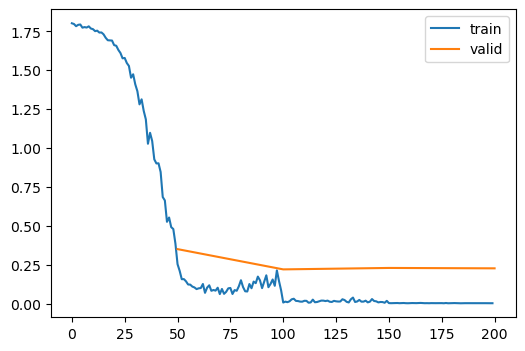

accuracy,loss,epoch,train,time
0.490,1.421,0,True,00:01
0.894,0.417,0,False,00:00
0.965,0.123,1,True,00:01
0.925,0.216,1,False,00:00
0.998,0.011,2,True,00:01
0.927,0.224,2,False,00:00
1.000,0.002,3,True,00:01
0.927,0.223,3,False,00:00


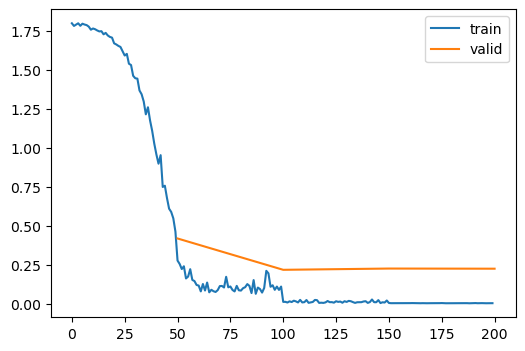

accuracy,loss,epoch,train,time
0.533,1.380,0,True,00:01
0.928,0.357,0,False,00:00
0.965,0.115,1,True,00:01
0.922,0.225,1,False,00:00
0.997,0.013,2,True,00:01
0.925,0.230,2,False,00:00
1.000,0.002,3,True,00:01
0.925,0.230,3,False,00:00


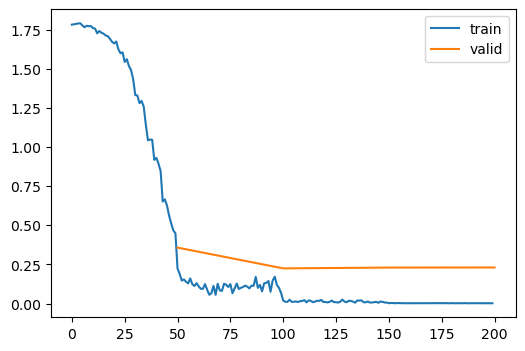

accuracy,loss,epoch,train,time
0.519,1.384,0,True,00:01
0.916,0.384,0,False,00:00
0.965,0.124,1,True,00:02
0.928,0.214,1,False,00:00
0.998,0.012,2,True,00:01
0.927,0.224,2,False,00:00
1.000,0.003,3,True,00:01
0.927,0.224,3,False,00:00


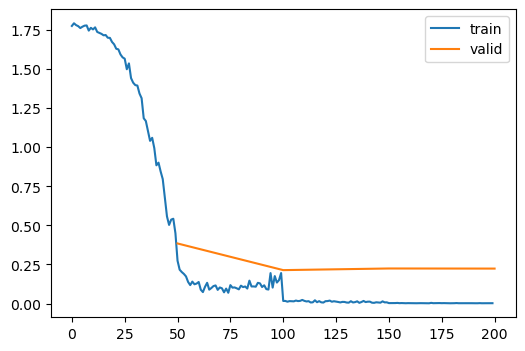

accuracy,loss,epoch,train,time
0.527,1.399,0,True,00:01
0.931,0.380,0,False,00:00
0.961,0.132,1,True,00:01
0.921,0.220,1,False,00:00
0.996,0.017,2,True,00:01
0.929,0.211,2,False,00:00
1.000,0.003,3,True,00:01
0.932,0.206,3,False,00:00


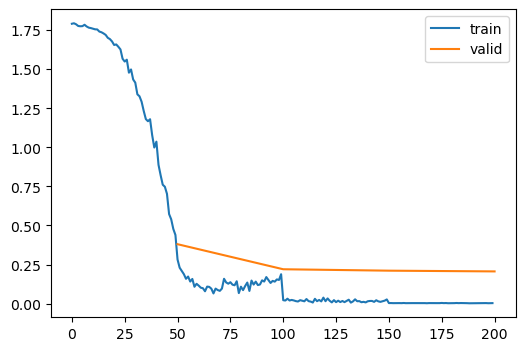

accuracy,loss,epoch,train,time
0.525,1.390,0,True,00:01
0.889,0.427,0,False,00:00
0.960,0.139,1,True,00:01
0.925,0.214,1,False,00:00
0.997,0.015,2,True,00:01
0.922,0.221,2,False,00:00
1.000,0.003,3,True,00:01
0.922,0.218,3,False,00:00


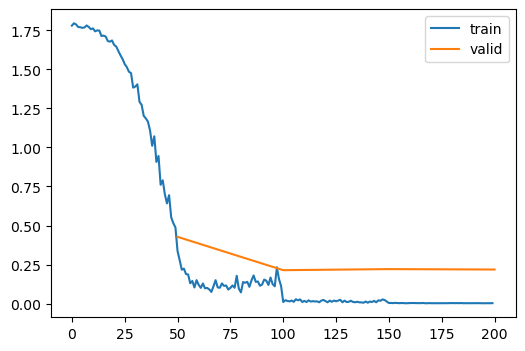

accuracy,loss,epoch,train,time
0.492,1.394,0,True,00:01
0.921,0.367,0,False,00:00
0.962,0.128,1,True,00:01
0.911,0.257,1,False,00:00
0.996,0.018,2,True,00:01
0.921,0.236,2,False,00:00
1.000,0.003,3,True,00:01
0.919,0.235,3,False,00:00


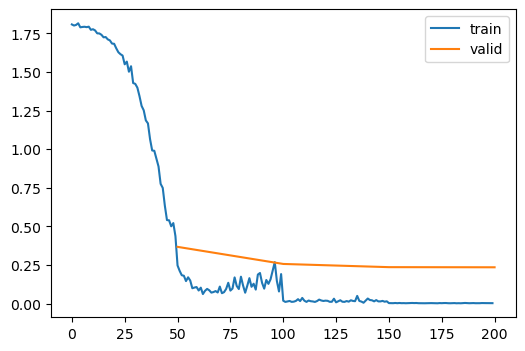

accuracy,loss,epoch,train,time
0.508,1.399,0,True,00:01
0.922,0.379,0,False,00:00
0.964,0.123,1,True,00:01
0.923,0.218,1,False,00:00
0.997,0.013,2,True,00:01
0.922,0.227,2,False,00:00
1.000,0.003,3,True,00:01
0.920,0.228,3,False,00:00


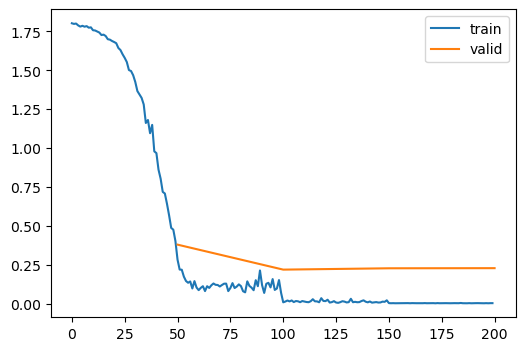

accuracy,loss,epoch,train,time
0.531,1.393,0,True,00:01
0.926,0.377,0,False,00:00
0.965,0.122,1,True,00:01
0.919,0.226,1,False,00:00
0.996,0.016,2,True,00:01
0.926,0.219,2,False,00:00
1.000,0.003,3,True,00:01
0.924,0.225,3,False,00:00


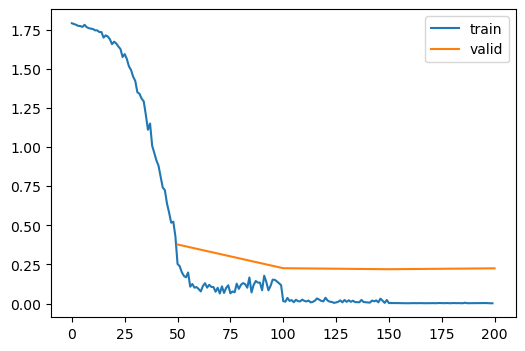

accuracy,loss,epoch,train,time
0.508,1.396,0,True,00:01
0.925,0.366,0,False,00:00
0.964,0.121,1,True,00:01
0.918,0.227,1,False,00:00
0.997,0.015,2,True,00:01
0.918,0.226,2,False,00:00
1.000,0.003,3,True,00:01
0.918,0.226,3,False,00:00


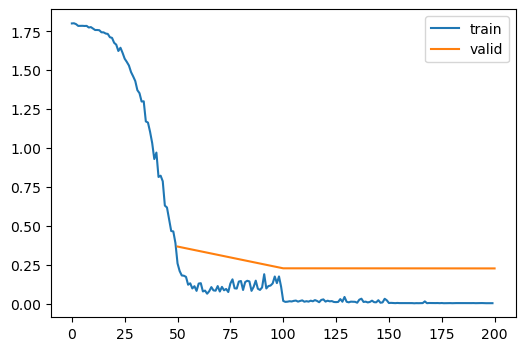

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.648,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.882,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.603,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.609,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.662,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.466,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.258,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.328,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.429,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.260,0,False,00:00


0.833

In [74]:
lr, epochs = 1e-3, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


accuracy,loss,epoch,train,time
0.480,1.510,0,True,00:02
0.827,0.697,0,False,00:00
0.955,0.184,1,True,00:01
0.916,0.251,1,False,00:00
0.996,0.019,2,True,00:01
0.915,0.265,2,False,00:00
1.000,0.002,3,True,00:01
0.917,0.257,3,False,00:00
1.000,0.001,4,True,00:01
0.917,0.257,4,False,00:00


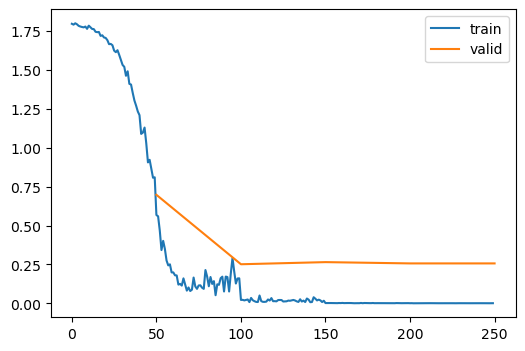

accuracy,loss,epoch,train,time
0.453,1.497,0,True,00:01
0.861,0.648,0,False,00:00
0.956,0.169,1,True,00:01
0.919,0.236,1,False,00:00
0.995,0.019,2,True,00:01
0.918,0.252,2,False,00:00
1.000,0.002,3,True,00:01
0.916,0.257,3,False,00:00
1.000,0.001,4,True,00:01
0.916,0.257,4,False,00:00


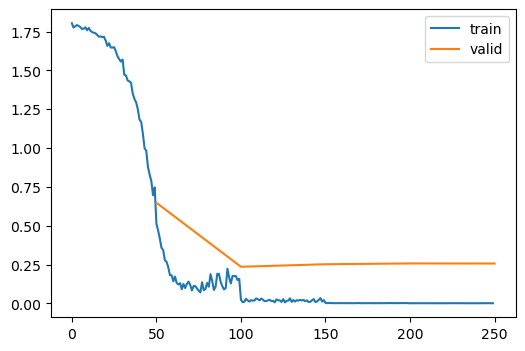

accuracy,loss,epoch,train,time
0.486,1.488,0,True,00:01
0.851,0.642,0,False,00:00
0.957,0.170,1,True,00:01
0.925,0.218,1,False,00:00
0.995,0.018,2,True,00:01
0.923,0.221,2,False,00:00
1.000,0.002,3,True,00:01
0.926,0.220,3,False,00:00
1.000,0.001,4,True,00:01
0.927,0.220,4,False,00:00


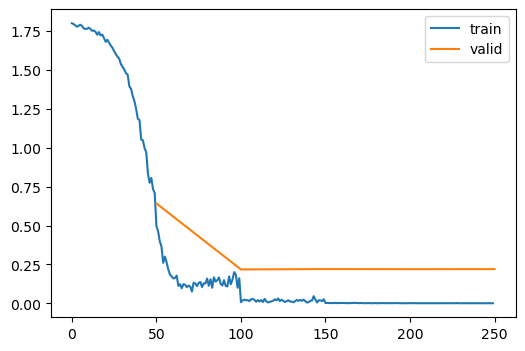

accuracy,loss,epoch,train,time
0.441,1.528,0,True,00:01
0.862,0.689,0,False,00:00
0.956,0.176,1,True,00:01
0.915,0.243,1,False,00:00
0.996,0.016,2,True,00:01
0.920,0.241,2,False,00:00
1.000,0.002,3,True,00:01
0.923,0.238,3,False,00:00
1.000,0.001,4,True,00:01
0.924,0.238,4,False,00:00


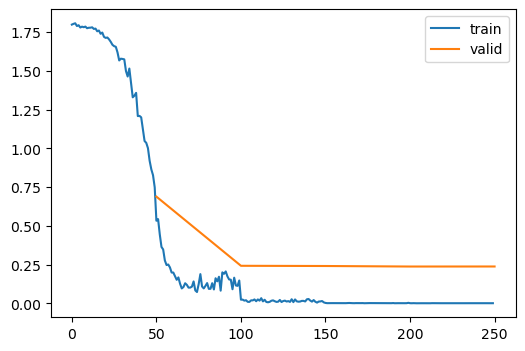

accuracy,loss,epoch,train,time
0.477,1.503,0,True,00:01
0.798,0.697,0,False,00:00
0.947,0.194,1,True,00:01
0.914,0.257,1,False,00:00
0.994,0.021,2,True,00:01
0.916,0.254,2,False,00:00
1.000,0.002,3,True,00:01
0.916,0.255,3,False,00:00
1.000,0.002,4,True,00:01
0.918,0.255,4,False,00:00


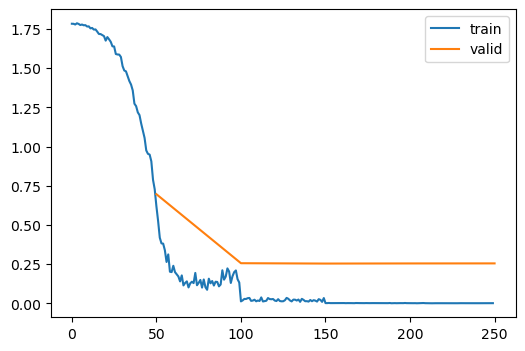

accuracy,loss,epoch,train,time
0.507,1.489,0,True,00:01
0.877,0.645,0,False,00:00
0.954,0.173,1,True,00:01
0.910,0.263,1,False,00:00
0.995,0.020,2,True,00:01
0.916,0.260,2,False,00:00
1.000,0.002,3,True,00:01
0.920,0.259,3,False,00:00
1.000,0.001,4,True,00:02
0.919,0.259,4,False,00:00


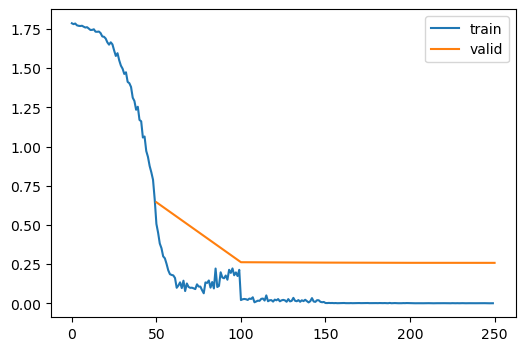

accuracy,loss,epoch,train,time
0.475,1.531,0,True,00:01
0.847,0.741,0,False,00:00
0.951,0.196,1,True,00:01
0.922,0.232,1,False,00:00
0.996,0.019,2,True,00:01
0.924,0.230,2,False,00:00
1.000,0.002,3,True,00:01
0.925,0.232,3,False,00:00
1.000,0.001,4,True,00:01
0.926,0.232,4,False,00:00


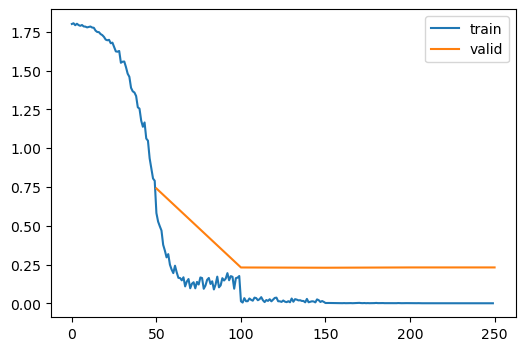

accuracy,loss,epoch,train,time
0.438,1.512,0,True,00:01
0.842,0.665,0,False,00:00
0.955,0.172,1,True,00:01
0.917,0.237,1,False,00:00
0.995,0.017,2,True,00:01
0.918,0.232,2,False,00:00
1.000,0.002,3,True,00:01
0.922,0.233,3,False,00:00
1.000,0.001,4,True,00:01
0.921,0.234,4,False,00:00


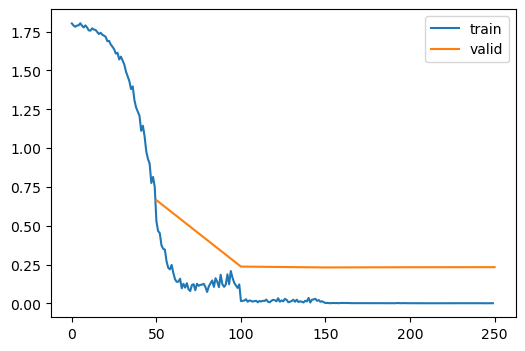

accuracy,loss,epoch,train,time
0.480,1.489,0,True,00:01
0.855,0.613,0,False,00:00
0.957,0.164,1,True,00:01
0.918,0.229,1,False,00:00
0.995,0.019,2,True,00:01
0.919,0.238,2,False,00:00
1.000,0.002,3,True,00:01
0.923,0.239,3,False,00:00
1.000,0.001,4,True,00:01
0.923,0.239,4,False,00:00


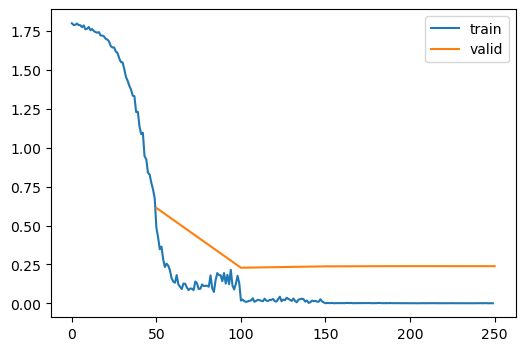

accuracy,loss,epoch,train,time
0.462,1.515,0,True,00:01
0.872,0.642,0,False,00:00
0.958,0.173,1,True,00:01
0.917,0.242,1,False,00:00
0.994,0.021,2,True,00:01
0.922,0.235,2,False,00:00
1.000,0.002,3,True,00:01
0.925,0.241,3,False,00:00
1.000,0.001,4,True,00:01
0.926,0.241,4,False,00:00


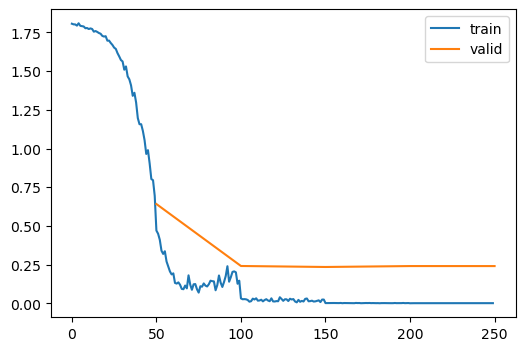

Making inference on test data


accuracy,loss,epoch,train,time
0.833,0.478,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.359,0,False,00:00


accuracy,loss,epoch,train,time
0.917,0.447,0,False,00:00


accuracy,loss,epoch,train,time
0.833,1.270,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.685,0,False,00:00


accuracy,loss,epoch,train,time
0.833,1.076,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.632,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.731,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.504,0,False,00:00


accuracy,loss,epoch,train,time
0.833,0.393,0,False,00:00


0.833

In [75]:
lr, epochs = 1e-3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.